<a href="https://colab.research.google.com/github/matteoromanato/Amazon-review-Sentiment-analysis/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import lib

In [1]:
!pip install afinn
!pip install nlpaug

     |████████████████████████████████| 61kB 5.4MB/s 
  Created wheel for afinn: filename=afinn-0.1-cp36-none-any.whl size=53451 sha256=ae876236711d8672e5b23ca41c7d2ace0b17e0f4ea54e339767002532de066d0
  Stored in directory: /root/.cache/pip/wheels/b5/1c/de/428301f3333ca509dcf20ff358690eb23a1388fbcbbde008b2
Successfully built afinn
     |████████████████████████████████| 389kB 7.4MB/s 


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string

from PIL import Image
from wordcloud import WordCloud

from collections import Counter
import itertools
import os
import io

In [3]:
from afinn import Afinn
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import TweetTokenizer  # metodo apposta per twitter
from nltk.stem.lancaster import LancasterStemmer  # stemming

import nlpaug.augmenter.word as naw
from nlpaug.util import Action

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
!pip install gensim
import gensim.downloader as api
import string
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
# stop word list update

stop =stopwords.words('english')
stop =set(stop)
stop.add("The")
stop.add("It")
stop.add("My")
stop.add("'s")
stop.add("I")
stop.add(".<br")
stop.add("br")
stop.add("/><br")
stop.add("'t")
stop.add("'ve")
stop.add("use")
stop.add("one")
stop.add("br")
stop.add("This")
stop.add("They")
stop.add("product")

punctuation = string.punctuation

# functions

In [8]:
# Function to get the counter

def get_counter(df):
  sentences = (list(itertools.chain(df)))
  flat_list = [item for sublist in sentences for item in sublist]
  c = Counter(flat_list)
  return c


### lexicon base approach functions

In [9]:
def boxplot_graph(df,x,y):
  """
  Create a box plot 
  Parameters:
    df:   dataframe
    x:    features on x 
    y:    features on y 
  """

  sns.set_theme(style="whitegrid", palette="pastel")
  plt.figure(figsize=(10,8))
  sns.boxplot(x=x, y=y, hue="score", palette=sns.color_palette("hls", 8) , data=df)
  sns.despine(offset=30, trim=True)

In [10]:
"""
These function provide a category classification of the attribute score, afinn_score, compound
Parameters:
  x:    value

"""

def target(x):
  if x <= -0.5:
    return -1
  elif x > -0.5 and x < 0.5:
    return 0
  else:
    return 1

def target_a(x):
  if x < -3:
    return -1
  elif x >= -3 and x <= 3:
    return 0
  else:
    return 1

def target_s(x):
  if x <= 2:
    return -1
  elif x > 3:
    return 1
  else:
    return 0

In [11]:
def pieplot_graph(string,n):
  """
  Crete a pieplot for different category score based on parameter n
  Parameters:
    string:   category name
    n:        = 1 for category_vader
              = 2 for category_afinn
              = 3 for category_score
  """
  if n == 1:
    gr = df.groupby(string)
    uno = gr.get_group(0).count().category_vader
    due = gr.get_group(1).count().category_vader
    zero = gr.get_group(-1).count().category_vader
    size = [zero,uno,due]

    labels = ['-1', '0', '1']
    explode = (0.05, 0.09,0.05) 

    fig1, ax1 = plt.subplots()
    ax1.pie(size, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)

    ax1.axis('equal')  
    plt.title(string)
  if n == 2:
    gr = df.groupby(string)
    uno = gr.get_group(0).count().category_afinn
    due = gr.get_group(1).count().category_afinn
    zero = gr.get_group(-1).count().category_afinn
    size = [zero,uno,due]

    labels = ['-1', '0', '1']
    explode = (0.05, 0.09,0.05) 

    fig1, ax1 = plt.subplots()
    ax1.pie(size, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)

    ax1.axis('equal')  
    plt.title(string)
  if n == 3:
    
    gr = df.groupby(string)
    uno = gr.get_group(0).count().category_score
    due = gr.get_group(1).count().category_score
    zero = gr.get_group(-1).count().category_score
    size = [zero,uno,due]

    labels = ['-1', '0', '1']
    explode = (0.05, 0.09,0.05) 

    fig1, ax1 = plt.subplots()
    ax1.pie(size, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)

    ax1.axis('equal')  
    plt.title(string)

In [12]:
"""
Given a confusion matrix provide different metrics
Metrics:  recall and micro_recal
          precision and micro_precision
          f1-score 
"""

def get_recall(confusion):
  recall_1 = confusion[-1][-1] / (confusion[-1][0] + confusion[-1][1] + confusion[-1][-1])
  recall0 = confusion[0][0] / (confusion[0][-1] + confusion[0][1] + confusion[0][0])
  recall1 = confusion[1][1] / (confusion[1][0] + confusion[1][-1] + confusion[1][1])
  recall = [recall_1,recall0,recall1]
  element_recall = [5224, 2860, 27088]

  micro_recall = 0
  for i in range(-1,2):
    #print("{} / {} * {}".format(element_recall[i+1],np.sum(confusion.values), recall[i+1]))
    micro_recall = micro_recall + ((element_recall[i+1]/np.sum(confusion.values)) * recall[i+1])
  print("micro recall:", micro_recall)  

  macro_recall = np.sum(recall)/3
  print("Macro recall: ",macro_recall)
  print()
  return recall_1, recall0, recall1, micro_recall, macro_recall

def get_precision(confusion):
  precision_1 = confusion[-1][-1] / (confusion[0][-1] + confusion[1][-1] + confusion[-1][-1])
  precision0 = confusion[0][0] / (confusion[-1][0] + confusion[1][0] + confusion[0][0])
  precision1 = confusion[1][1] / (confusion[0][1] + confusion[-1][1] + confusion[1][1])
  precision = [precision_1, precision0, precision1]

  micro_precision = 0
  for i in range(-1,2):
    #print("{} / {} * {}".format(np.sum(confusion[:][i]),np.sum(confusion.values), precision[i+1]))
    micro_precision = micro_precision + ((np.sum(confusion[:][i])/np.sum(confusion.values)) * precision[i+1])
  print("\nmicro precision:", micro_precision) 

  macro_prec = np.sum(precision)/3
  print("Macro precision: ",macro_prec)
  print()

  return precision_1, precision0, precision1, micro_precision, macro_prec

def get_f1(rec,prec):
  f1 = 1/(1/2*(1/rec + 1/prec))
  return f1

In [13]:
def print_metrics(confusion):
  """
  plot the confusion matrix and some metrics
  """
  
  accuracy = np.sum(np.diag(confusion)) / np.sum(confusion.values)
  print("\n\n--- Afinn score ---")
  print("Accuracy: \t{}\n".format(accuracy))

  #precision
  precision_1, precision0, precision1, micro_precision, macro_precision = get_precision(confusion)

  #recall
  recall_1, recall0, recall1, micro_recall, macro_recall = get_recall(confusion)

  #f1_score
  print("micro f1-score: ", get_f1(micro_recall,micro_precision))
  print("macro f1-score: ", get_f1(macro_recall,macro_precision))

  sns.heatmap(confusion, annot=True, fmt="d", cmap="YlGnBu", linewidths=.5)
  plt.title("confusion matrix")
  plt.ylabel("Categoria score")
  plt.xlabel("Categoria valutata")
  return precision_1, precision0, precision1, recall_1, recall0, recall1

### analysis functions

In [14]:
def recap_user(userdf, num):
  """
  plot data of user
  """
  fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
  fig.suptitle(str('Recensioni utente {}'.format(num)))
  axes[1].set_title("line plot")
  axes[0].set_title("Distribuzione delle recensioni nel tempo")
  
  sns.lineplot(ax = axes[1], data = userdf, y='Time', x = 'score')
  sns.swarmplot(ax = axes[0], data = userdf, y='Time', x = 'score')

In [15]:
def pie_plot_prod(df, stringa):
  """
  plot a pie plot of a attribute distribution from a dataframe
  """
  df[df.productid == stringa]
  values = df[df['productid']==stringa].score.value_counts()
  values[5.0]

  size = [values[5.0],values[4.0],values[3.0],values[2.0],values[1.0]]

  labels = ['5','4','3','2','1']
  explode = (0, 0,0,0.1,0.1) 

  fig, ax = plt.subplots()
  ax.pie(size, explode=explode, labels=labels, autopct='%1.1f%%',
          shadow=True, startangle=90)


In [16]:
def preprocess(sent):
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    nomi = [token for (token, tag) in sent if (tag=="NN" or tag == "NNP")]
    return nomi

In [17]:
# serve per estrarre tutti i nomi dalle recensioni dei prodotti

def get_counter_product(nomi):
  flat_list1 = []
  sentences = (list(itertools.chain(nomi)))
  flat_list = [item for sublist in sentences for item in sublist]
  flat_list = [item for item in flat_list if item not in stop]
  flat_list = [item for item in flat_list if item not in punctuation]
  #print(flat_list)
  c = Counter(flat_list)
  return c


In [18]:
def categoria_prodotto(text):
  try:
    nomi = []
    nomi.append(preprocess(text))

    c = get_counter_product(nomi)
    c.most_common(3)
    categoria = (np.array(c.most_common(1))[0][0])
    #print(categoria)
    return categoria
  except:
    pass

In [19]:
def recap_categoria(df, cat):
  fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharey=True)
  fig.suptitle(str('Recensioni utente - {}'.format(cat)))
  axes[0].set_title("line plot")
  axes[1].set_title("Distribuzione delle recensioni nel tempo")

  sns.swarmplot(ax = axes[1], data = df, y='Time', x = 'score')
  sns.lineplot(ax = axes[0],data = df, y='Time', x = 'score')

#Import Data 

<h3> Introduction </h3>

```
In this part I imported the dataset 'food.tsv' and I merge it with fineFood dataset found on Kaggle

I visualized the data type and I plotted the frequency of the feature 'score'
```



In [20]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/progetto_Data_analytics/')


Mounted at /content/drive


In [21]:
df1 = pd.read_csv('food.tsv', sep='\t', encoding='windows-1252')
df1['Id'] = df1.index
df1.head(3)

,productid,userid,score,text,Id
0,B001E4KFG0,A3SGXH7AUHU8GW,5.0,I have bought several of the Vitality canned d...,0
1,B00813GRG4,A1D87F6ZCVE5NK,1.0,Product arrived labeled as Jumbo Salted Peanut...,1
2,B000LQOCH0,ABXLMWJIXXAIN,4.0,This is a confection that has been around a fe...,2


In [22]:
df = pd.read_csv('Reviews.csv')
df['Id'] = df.index
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


> merge & features selection

In [23]:
tot = df1.merge(df, on='Id', how='left')
df = tot[['productid','userid','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','score','Summary','text','Time']]

In [24]:
df.head(8)

,productid,userid,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,score,Summary,text,Time
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5.0,Good Quality Dog Food,I have bought several of the Vitality canned d...,1303862400
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1.0,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,1346976000
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4.0,"""Delight"" says it all",This is a confection that has been around a fe...,1219017600
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2.0,Cough Medicine,If you are looking for the secret ingredient i...,1307923200
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5.0,Great taffy,Great taffy at a great price. There was a wid...,1350777600
5,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4.0,Nice Taffy,I got a wild hair for taffy and ordered this f...,1342051200
6,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5.0,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,1340150400
7,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5.0,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...,1336003200


In [25]:
print("score: {}\t text: {}".format(df.loc[0].score,df.loc[0].text))
print("score: {}\t text: {}".format(df.loc[1].score,df.loc[1].text))
print("score: {}\t text: {}".format(df.loc[3].score,df.loc[3].text))
print("score: {}\t text: {}".format(df.loc[35171].score,df.loc[35171].text))

score: 5.0	 text: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
score: 1.0	 text: Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
score: 2.0	 text: If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The flavor is very medicinal.
score: 5.0	 text: This sauce gives you authentic tonkatsu flavor - and six bottles of it! The bottle tops are cleverly designed to allow pouring or precise squeezing of the precious sauce.


In [26]:
df.dtypes

productid                  object
userid                     object
ProfileName                object
HelpfulnessNumerator        int64
HelpfulnessDenominator      int64
score                     float64
Summary                    object
text                       object
Time                        int64
dtype: object

In [27]:
df.isna().count()

productid                 35172
userid                    35172
ProfileName               35172
HelpfulnessNumerator      35172
HelpfulnessDenominator    35172
score                     35172
Summary                   35172
text                      35172
Time                      35172
dtype: int64

In [28]:
df.describe()

,HelpfulnessNumerator,HelpfulnessDenominator,score,Time
count,35172.000000,35172.000000,35172.000000,3.517200e+04
mean,1.558427,2.002161,4.156119,1.294225e+09
std,5.379771,5.983567,1.317022,4.694514e+07
min,0.000000,0.000000,1.000000,9.617184e+08
25%,0.000000,0.000000,4.000000,1.268006e+09
50%,0.000000,1.000000,5.000000,1.306973e+09
75%,1.000000,2.000000,5.000000,1.329782e+09
max,203.000000,219.000000,5.000000,1.351210e+09


In [29]:
# stile grafici

sns.set_theme(style="ticks", palette="pastel")
plt.figure(figsize=(20,20))

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

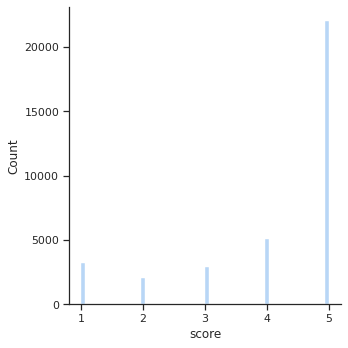

In [30]:
# plot the distribution of the score

sns.displot(df['score'], facet_kws=dict(margin_titles=True))

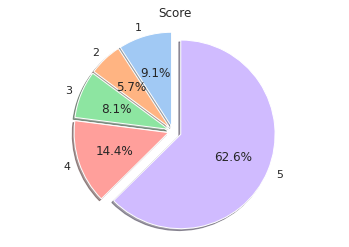

In [31]:
gr = df.groupby('score')
uno = gr.get_group(1).count().score
due = gr.get_group(2).count().score
tre = gr.get_group(3).count().score
quattro = gr.get_group(4).count().score
cinque = gr.get_group(5).count().score

size = [uno,due,tre,quattro,cinque]

labels = ['1', '2', '3','4','5']
explode = (0.05, 0.05,0.05,0.05,0.09) 

fig1, ax1 = plt.subplots()
ax1.pie(size, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Score')
plt.show()

# Lexicon base approaches






<h3> Sentiment Score <h3>


1.   Vader score
2.   Afinn score

## Vader score 



```
The VADER library returns 4 values such as:

pos: The probability of the sentiment to be positive
neu: The probability of the sentiment to be neutral
neg: The probability of the sentiment to be negative
compound: The normalized compound score which calculates the sum of all lexicon ratings and takes values from -1 to 1

Notice that the pos, neu and neg probabilities add up to 1.
Also, the compound score is a very useful metric in case we want a single measure of sentiment. Typical threshold values are the following:

positive: compound score>=0.5
neutral: compound score between -0.5 and 0.5
negative: compound score<=-0.5
```



In [32]:
analyzer = SentimentIntensityAnalyzer()

# example
res = analyzer.polarity_scores("This pizza is very good, I love it")
print("neg: {}".format(res['neg']))           
print("neu: {}".format(res['neu']))           
print("pos: {}".format(res['pos']))           
print("compound: {}".format(res['compound'])) 

neg: 0.0
neu: 0.395
pos: 0.605
compound: 0.8258


In [33]:
# apply this score to the whole dataset in base of the text

df['neg'] = df['text'].apply(lambda x:analyzer.polarity_scores(x)['neg'])
df['neu'] = df['text'].apply(lambda x:analyzer.polarity_scores(x)['neu'])
df['pos'] = df['text'].apply(lambda x:analyzer.polarity_scores(x)['pos'])
df['compound'] = df['text'].apply(lambda x:analyzer.polarity_scores(x)['compound'])
df.head(3)

,productid,userid,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,score,Summary,text,Time,neg,neu,pos,compound
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5.0,Good Quality Dog Food,I have bought several of the Vitality canned d...,1303862400,0.000,0.695,0.305,0.9441
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1.0,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,1346976000,0.138,0.862,0.000,-0.5664
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4.0,"""Delight"" says it all",This is a confection that has been around a fe...,1219017600,0.091,0.754,0.155,0.8265


In [34]:
df.query('score >= 4.0 and compound < 0.5 ')

,productid,userid,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,score,Summary,text,Time,neg,neu,pos,compound
5,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4.0,Nice Taffy,I got a wild hair for taffy and ordered this f...,1342051200,0.000,0.856,0.144,0.4927
11,B0009XLVG0,A2725IB4YY9JEB,"A Poeng ""SparkyGoHome""",4,4,5.0,"My cats LOVE this ""diet"" food better than thei...",One of my boys needed to lose some weight and ...,1282867200,0.113,0.887,0.000,-0.7579
23,B001GVISJM,AJ613OLZZUG7V,Mare's,0,0,5.0,Twizzlers,I love this candy. After weight watchers I ha...,1304467200,0.085,0.771,0.143,0.2617
24,B001GVISJM,A22P2J09NJ9HKE,"S. Cabanaugh ""jilly pepper""",0,0,5.0,Please sell these in Mexico!!,"I have lived out of the US for over 7 yrs now,...",1295481600,0.038,0.895,0.068,0.3939
25,B001GVISJM,A3FONPR03H3PJS,"Deborah S. Linzer ""Cat Lady""",0,0,5.0,Twizzlers - Strawberry,Product received is as advertised.<br /><br />...,1288310400,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35120,B000YT3IO2,ASOYUDLYTQML3,"Margaret E. Peet ""tree hugger""",0,0,5.0,Good and low cal.,I like this dressing that I take to work with ...,1264118400,0.000,0.815,0.185,0.3612
35132,B0012LAFG0,A2GH9V93XKCW0X,Audio\Video Techie,1,1,5.0,Best Chips Ever Made!,These are the best chips I have ever tasted. ...,1275004800,0.046,0.897,0.057,0.3544
35142,B001EO5RBS,A2YAHDOYQK3JJJ,"Roger D. Lauzon ""coaterfreak""",1,1,5.0,great cooking and stir fry oil,hi buy this oil for all your stir frying and d...,1335657600,0.000,0.897,0.103,0.4939
35162,B000E1DSQS,A2XC6AIMR3E94H,"Barbi Lee ""Barbi""",4,4,5.0,Really good to the last drop,I did a research project on different coffees ...,1215043200,0.042,0.898,0.060,0.2465


In [35]:
df.loc[11].text

"One of my boys needed to lose some weight and the other didn't.  I put this food on the floor for the chubby guy, and the protein-rich, no by-product food up higher where only my skinny boy can jump.  The higher food sits going stale.  They both really go for this food.  And my chubby boy has been losing about an ounce a week."

In [36]:
df.groupby('score')['compound'].describe()

,count,mean,std,min,25%,50%,75%,max
score,,,,,,,,
1.0,3218.0,0.020235,0.631119,-0.9955,-0.583975,0.00000,0.612000,0.9994
2.0,2006.0,0.278708,0.587330,-0.9874,-0.212550,0.43310,0.821600,0.9971
3.0,2860.0,0.456915,0.522271,-0.9841,0.088650,0.66605,0.888875,0.9984
4.0,5071.0,0.674485,0.390855,-0.9516,0.585350,0.83330,0.932750,0.9981
5.0,22017.0,0.754752,0.326408,-0.9803,0.718100,0.88020,0.944400,0.9992


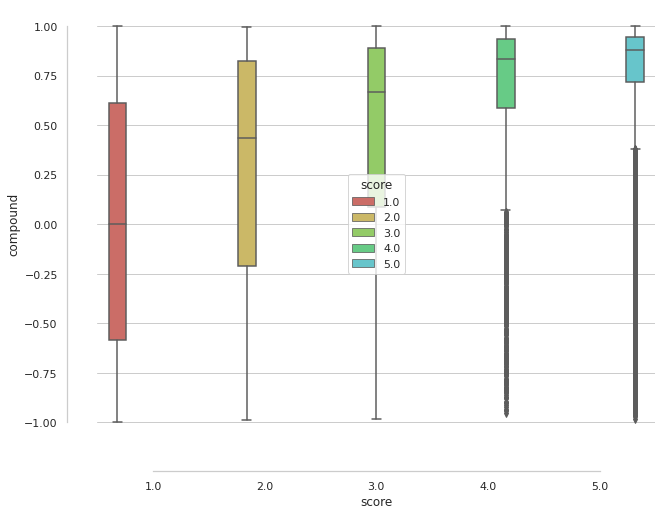

In [37]:
boxplot_graph(df,df.score,df.compound)

## Afinn score 

`AFINN sentiment analysis in Python: Wordlist-based approach for sentiment analysis`

In [38]:
afinn = Afinn()
df['afinn'] = df['text'].apply(afinn.score)
df.head(10)

,productid,userid,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,score,Summary,text,Time,neg,neu,pos,compound,afinn
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5.0,Good Quality Dog Food,I have bought several of the Vitality canned d...,1303862400,0.000,0.695,0.305,0.9441,16.0
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1.0,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,1346976000,0.138,0.862,0.000,-0.5664,-2.0
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4.0,"""Delight"" says it all",This is a confection that has been around a fe...,1219017600,0.091,0.754,0.155,0.8265,3.0
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2.0,Cough Medicine,If you are looking for the secret ingredient i...,1307923200,0.000,1.000,0.000,0.0000,3.0
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5.0,Great taffy,Great taffy at a great price. There was a wid...,1350777600,0.000,0.552,0.448,0.9468,9.0
5,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4.0,Nice Taffy,I got a wild hair for taffy and ordered this f...,1342051200,0.000,0.856,0.144,0.4927,2.0
6,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5.0,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,1340150400,0.034,0.693,0.273,0.9346,6.0
7,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5.0,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...,1336003200,0.000,0.520,0.480,0.9487,9.0
8,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5.0,Yay Barley,Right now I'm mostly just sprouting this so my...,1322006400,0.000,0.851,0.149,0.6369,3.0
9,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5.0,Healthy Dog Food,This is a very healthy dog food. Good for thei...,1351209600,0.000,0.705,0.295,0.8313,8.0


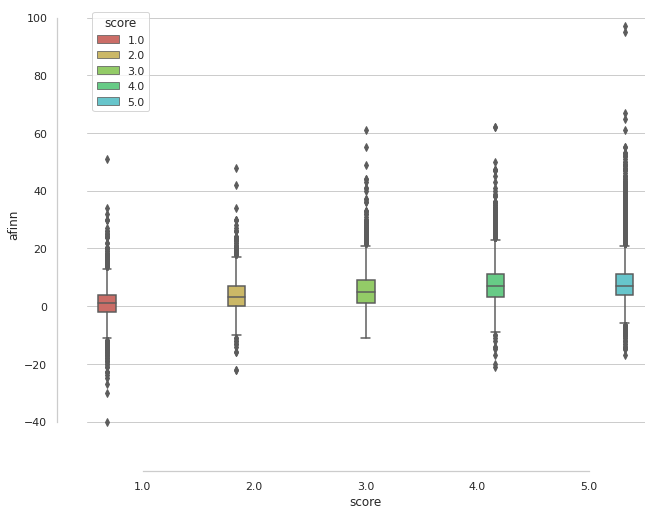

In [39]:
boxplot_graph(df,df.score,df.afinn)

##target values

In [40]:
df['category_vader']=df['compound'].apply(lambda x: target(x))
df['category_afinn']=df['afinn'].apply(lambda x: target_a(x))
df['category_score']=df['score'].apply(lambda x: target_s(x))
df.head(5)

,productid,userid,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,score,Summary,text,Time,neg,neu,pos,compound,afinn,category_vader,category_afinn,category_score
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5.0,Good Quality Dog Food,I have bought several of the Vitality canned d...,1303862400,0.000,0.695,0.305,0.9441,16.0,1,1,1
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1.0,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,1346976000,0.138,0.862,0.000,-0.5664,-2.0,-1,0,-1
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4.0,"""Delight"" says it all",This is a confection that has been around a fe...,1219017600,0.091,0.754,0.155,0.8265,3.0,1,0,1
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2.0,Cough Medicine,If you are looking for the secret ingredient i...,1307923200,0.000,1.000,0.000,0.0000,3.0,0,0,-1
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5.0,Great taffy,Great taffy at a great price. There was a wid...,1350777600,0.000,0.552,0.448,0.9468,9.0,1,1,1


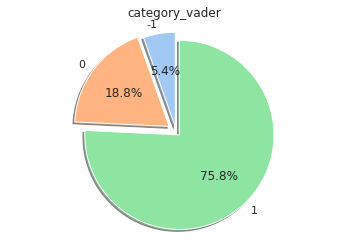

In [41]:
pieplot_graph('category_vader',1)

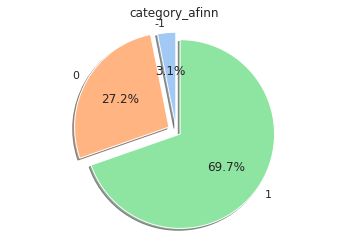

In [42]:
pieplot_graph('category_afinn',2)

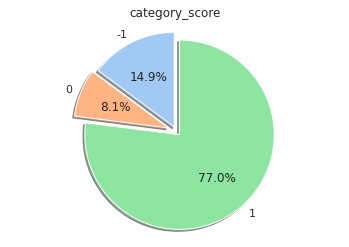

In [43]:
pieplot_graph('category_score',3)

## Metrics Lexicon-base approch 

> Metrics for Afinn score



--- Afinn score ---
Accuracy: 	0.6467360400318435


micro precision: 0.6461687079312699
Macro precision:  0.43222349024122425

micro recall: 0.7674256412671145
Macro recall:  0.5489016311709248

micro f1-score:  0.7015965157643747
macro f1-score:  0.4836247154334877


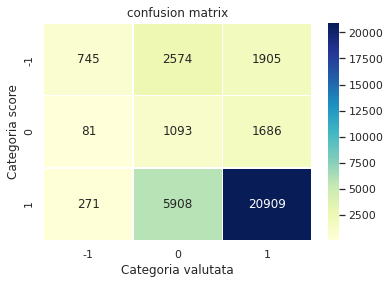

In [44]:
# Compute 3-class confusion matrix
confusion = pd.crosstab(df.category_score, (df.category_afinn)) 
precision_1, precision0, precision1, recall_1, recall0, recall1 = print_metrics(confusion)

> metrics for Vader score



--- Afinn score ---
Accuracy: 	0.7173888320254748


micro precision: 0.7199463509406234
Macro precision:  0.4733405775369284

micro recall: 0.7736930317850079
Macro recall:  0.5514700601922727

micro f1-score:  0.7458526889741546
macro f1-score:  0.509427102287186


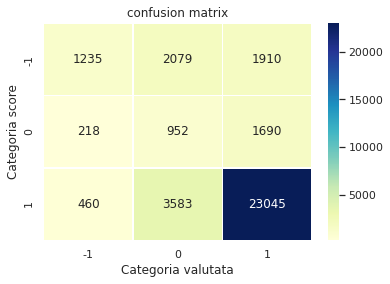

In [45]:
confusion_v = pd.crosstab(df.category_score, df.category_vader)
precision_1_v, precision0_v, precision1_v, recall_1_v, recall0_v, recall1_v = print_metrics(confusion_v)

#Analysis on user

In [46]:
df.head(3)

,productid,userid,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,score,Summary,text,Time,neg,neu,pos,compound,afinn,category_vader,category_afinn,category_score
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5.0,Good Quality Dog Food,I have bought several of the Vitality canned d...,1303862400,0.000,0.695,0.305,0.9441,16.0,1,1,1
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1.0,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,1346976000,0.138,0.862,0.000,-0.5664,-2.0,-1,0,-1
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4.0,"""Delight"" says it all",This is a confection that has been around a fe...,1219017600,0.091,0.754,0.155,0.8265,3.0,1,0,1


In [47]:
df['userid'].value_counts()

AY12DBB0U420B     30
A1Z54EM24Y40LL    28
A3OXHLG6DIBRW8    24
A2SZLNSI5KOQJT    21
A1YUL9PCJR3JTY    20
                  ..
A18ST4BF89DX10     1
A22BDVFIFLWPAQ     1
A2OMEID0VXZ73T     1
A35NE8XBANE7V1     1
A1T12UDN6JVOEF     1
Name: userid, Length: 29429, dtype: int64

In [48]:
# recensioni di AY12DBB0U420B

user1 = df[df['userid'] == 'AY12DBB0U420B']
user1

,productid,userid,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,score,Summary,text,Time,neg,neu,pos,compound,afinn,category_vader,category_afinn,category_score
109,B001REEG6C,AY12DBB0U420B,Gary Peterson,0,0,5.0,My Idea of a Good Diet Food.,I'm presently on a diet and I was at my Fresh ...,1316390400,0.014,0.764,0.222,0.9841,22.0,1,1,1
2196,B008YAXFWI,AY12DBB0U420B,Gary Peterson,0,0,4.0,"Mild Taste, But Delicious.",A nearby Fresh and Easy Neighborhood Market st...,1346630400,0.030,0.732,0.238,0.9472,15.0,1,1,1
3016,B0025UALB6,AY12DBB0U420B,Gary Peterson,0,0,4.0,Good Nutrition and Right Size.,"When I'm working, I always carry my own lunch....",1316736000,0.099,0.775,0.126,0.7700,7.0,1,1,1
3528,B005TY2REE,AY12DBB0U420B,Gary Peterson,0,0,4.0,No cholesterol. No Sodium. Not Very Sweet. Goo...,In my trip through the health area of my local...,1333756800,0.026,0.816,0.159,0.9104,8.0,1,1,1
3826,B000X2CWTM,AY12DBB0U420B,Gary Peterson,1,1,5.0,Mmmmmmmm!,I've always liked licorice candy and the best ...,1263340800,0.000,0.817,0.183,0.9354,24.0,1,1,1
7535,B00061KXUA,AY12DBB0U420B,Gary Peterson,0,0,5.0,"Oh, My! This Stuff Is Delicious!",My nearby Fresh and Easy Market (an English co...,1336176000,0.000,0.769,0.231,0.9660,18.0,1,1,1
12047,B003H7YHUW,AY12DBB0U420B,Gary Peterson,1,1,5.0,Excellent Sardines.,"For lunch today, I had a can of ""Wild Planet"" ...",1345075200,0.000,0.774,0.226,0.9545,14.0,1,1,1
12380,B000F5429A,AY12DBB0U420B,Gary Peterson,0,0,3.0,"Low in Calories. Weak Caramel Taste, Sorta.","I eat very little candy, but every once in a w...",1347753600,0.157,0.696,0.147,-0.0516,2.0,0,0,0
12909,B0036FOV2O,AY12DBB0U420B,Gary Peterson,4,5,5.0,Wonderful Aroma.,I've consumed coffee ever since my youth in th...,1264809600,0.010,0.809,0.180,0.9862,35.0,1,1,1
13818,B004TEVGHO,AY12DBB0U420B,Gary Peterson,0,0,5.0,Very Good Drink with a Minimum of Calories.,I like to try new things and we have a British...,1332201600,0.015,0.790,0.195,0.9754,17.0,1,1,1


Text(0.5, 1.0, 'user1 score')

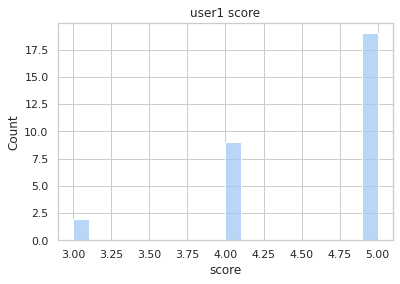

In [49]:
sns.histplot(data = user1.score, bins = 20)
plt.title("user1 score")

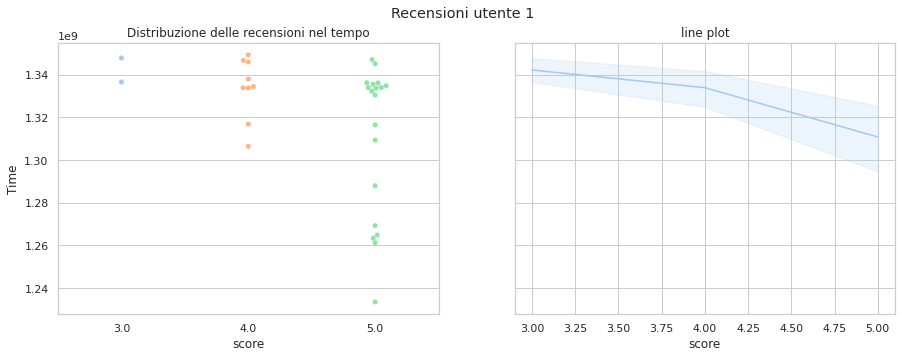

In [50]:
recap_user(user1, 1)

([<matplotlib.axis.YTick at 0x7fbd251fd518>,
 [Text(0, 0, '0'),
  Text(0, 0, '1'),
  Text(0, 0, '2'),
  Text(0, 0, '3'),
  Text(0, 0, '4'),
  Text(0, 0, '5')])

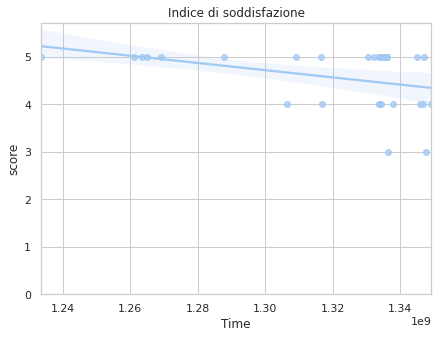

In [51]:
plt.figure(figsize=(7,5))
sns.regplot(data = user1, x='Time', y = 'score')
plt.title('Indice di soddisfazione')
plt.yticks(np.arange(6), labels=['0','1', '2', '3', '4', '5'])

Text(0.5, 1.0, 'Utilità delle recensioni')

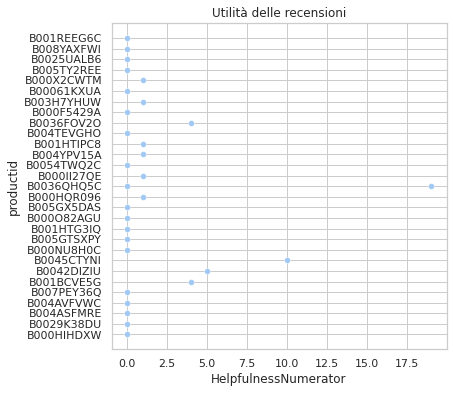

In [52]:
# utilità delle recensioni dell'utente 1
plt.figure(figsize=(6,6))
sns.scatterplot(data = user1, x = 'HelpfulnessNumerator', y='productid')
plt.title("Utilità delle recensioni")

In [53]:
[user1[(user1.category_afinn != user1.category_score) | (user1.category_vader != user1.category_score)]]

[        productid         userid  ... category_afinn  category_score
 23686  B000HQR096  AY12DBB0U420B  ...              1               0
 26310  B000O82AGU  AY12DBB0U420B  ...              0               1
 
 [2 rows x 17 columns]]

In [54]:
prova_1 = user1.loc[23686].text
prova_1

"I've enjoyed several of the Bar Harbor fish and shellfish soups and thought highly of them. As such, I thought I'd try their New England Style Corn Chowder. It was good. I enjoyed it. But, for the same price, I'd prefer their fish and shellfish soups' The sodium content is way to high, in my estimation, and then they say you can add salt if you like. This was an acceptable soup, but I probably won't buy it again.<br /><br />Gary Peterson"



> il primo utente, per numero di recensioni, che abbiamo ispezionato non ha evidenziato nessun fatto strato eccetto una recensione non molto chiara che è strana etichettata dai due score di sentiment come positiva ma in realtà era neutrale.

> Potremmo quindi supporre che l'utente esprime chiaramente la propria esperienza con i prodotti recensiti



In [55]:
user1['productid'].value_counts()

B0036QHQ5C    2
B000II27QE    1
B005GX5DAS    1
B0029K38DU    1
B0054TWQ2C    1
B005GTSXPY    1
B001BCVE5G    1
B000F5429A    1
B000X2CWTM    1
B0036FOV2O    1
B005TY2REE    1
B0042DIZIU    1
B000NU8H0C    1
B004YPV15A    1
B003H7YHUW    1
B004ASFMRE    1
B008YAXFWI    1
B000HIHDXW    1
B0025UALB6    1
B007PEY36Q    1
B001REEG6C    1
B001HTG3IQ    1
B000HQR096    1
B00061KXUA    1
B001HTIPC8    1
B000O82AGU    1
B004TEVGHO    1
B004AVFVWC    1
B0045CTYNI    1
Name: productid, dtype: int64

In [56]:
same_products = [user1[user1.productid == 'B0036QHQ5C']]
same_products[0]

# possiamo notare che entrambe le volte gli è piaciuto molto, ad avere anche la data si poteva confrontare di quanto è migliorato o peggiorato

,productid,userid,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,score,Summary,text,Time,neg,neu,pos,compound,afinn,category_vader,category_afinn,category_score
23227,B0036QHQ5C,AY12DBB0U420B,Gary Peterson,19,21,5.0,First Rate Blend.,"I really enjoy coffee, and I have ever since m...",1233446400,0.014,0.844,0.142,0.9937,20.0,1,1,1
23239,B0036QHQ5C,AY12DBB0U420B,Gary Peterson,0,0,4.0,"Promising Aroma, but Disappointing Coffee.",I enjoy whole-roasted coffee beans. Once you g...,1306368000,0.066,0.747,0.186,0.9917,26.0,1,1,1


Text(0.5, 1.0, 'score prodotto B0036QHQ5C')

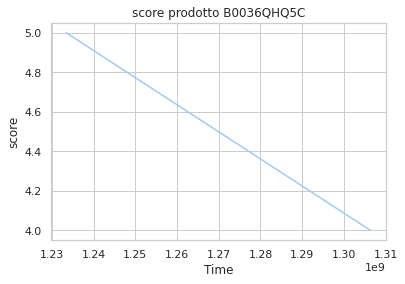

In [57]:
sns.lineplot(x="Time", y="score", data=user1[user1.productid == 'B0036QHQ5C'])
plt.title("score prodotto B0036QHQ5C")

> user 2

In [58]:
# recensioni di A1Z54EM24Y40LL    

user2 = df[df['userid'] == 'A1Z54EM24Y40LL']
user2.sort_values(by=['Time'])

,productid,userid,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,score,Summary,text,Time,neg,neu,pos,compound,afinn,category_vader,category_afinn,category_score
6371,B000084EKO,A1Z54EM24Y40LL,c2,0,0,3.0,Not any different than regular Friskies,I honestly cannot say that I saw any differenc...,1090800000,0.000,0.861,0.139,0.9287,9.0,1,1,0
6380,B000084EKG,A1Z54EM24Y40LL,c2,2,2,5.0,Awesome food!,This is my cat's favorite one. He just licks ...,1090972800,0.021,0.770,0.209,0.9642,15.0,1,1,1
6396,B000084EK7,A1Z54EM24Y40LL,c2,0,0,4.0,What's in this?,This one is a great basic food. Whatever is in...,1090972800,0.062,0.798,0.140,0.8592,10.0,1,1,1
6394,B000084EK5,A1Z54EM24Y40LL,c2,1,1,5.0,Family favorite - looks like steak!,This is my cat's third favorite food. It's gr...,1090972800,0.000,0.786,0.214,0.9412,10.0,1,1,1
6372,B000084EKA,A1Z54EM24Y40LL,c2,0,0,4.0,Not their best...,I think 9 Lives does a better job on this vari...,1090972800,0.087,0.820,0.093,0.1154,7.0,0,1,1
6393,B000084EK4,A1Z54EM24Y40LL,c2,0,0,3.0,Great beef look,"This food variety is ground, thus my cat doesn...",1090972800,0.021,0.765,0.213,0.9460,12.0,1,1,0
6374,B000084EKC,A1Z54EM24Y40LL,c2,1,1,5.0,Great food for all cats!,"According to my cat, this stuff is just great....",1090972800,0.041,0.691,0.268,0.9694,17.0,1,1,1
6375,B000084EKD,A1Z54EM24Y40LL,c2,1,1,2.0,Needs improved,I haven't had a cat yet that liked this one. ...,1090972800,0.032,0.868,0.101,0.6138,6.0,1,1,-1
6385,B000084EK9,A1Z54EM24Y40LL,c2,0,0,1.0,This stuff is bad!,I honestly have to say that I just won't buy t...,1090972800,0.104,0.733,0.163,0.5638,3.0,1,0,-1
6382,B000084EK8,A1Z54EM24Y40LL,c2,2,2,3.0,Not the favorite in our house,Once or twice a year for a little variety and ...,1090972800,0.039,0.783,0.179,0.9624,15.0,1,1,0


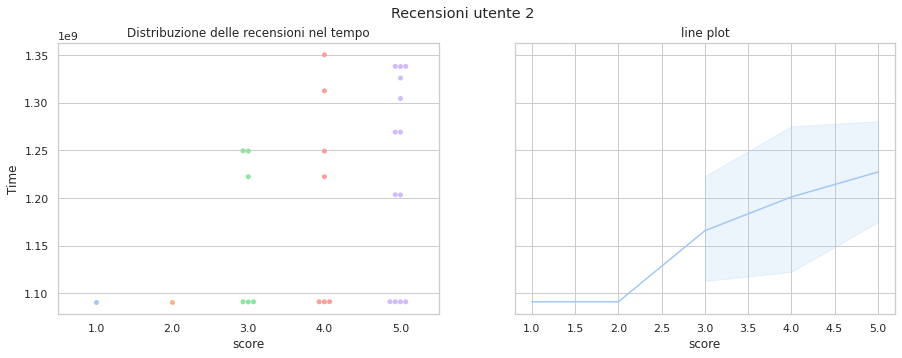

In [59]:
recap_user(user2, 2)

([<matplotlib.axis.YTick at 0x7fbd24f9dba8>,
 [Text(0, 0, '0'),
  Text(0, 0, '1'),
  Text(0, 0, '2'),
  Text(0, 0, '3'),
  Text(0, 0, '4'),
  Text(0, 0, '5')])

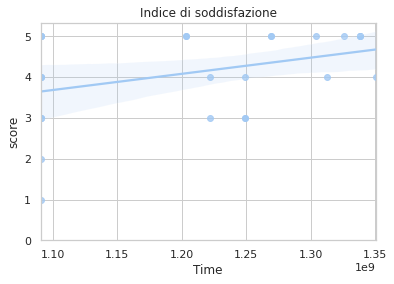

In [60]:
sns.regplot(data = user2, x='Time', y = 'score')
plt.title('Indice di soddisfazione')
plt.yticks(np.arange(6), labels=['0','1', '2', '3', '4', '5'])

Text(0.5, 1.0, 'Utilità delle recensioni')

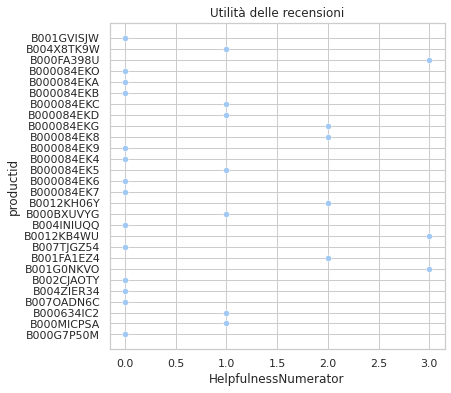

In [61]:
# utilità delle recensioni dell'utente 2

plt.figure(figsize=(6,6))
sns.scatterplot(data = user2, x = 'HelpfulnessNumerator', y='productid')
plt.title("Utilità delle recensioni")

In [62]:
strange = [user2[(user2.category_afinn != user2.category_score) | (user2.category_vader != user2.category_score)]]
strange

[        productid          userid  ... category_afinn  category_score
 6371   B000084EKO  A1Z54EM24Y40LL  ...              1               0
 6372   B000084EKA  A1Z54EM24Y40LL  ...              1               1
 6375   B000084EKD  A1Z54EM24Y40LL  ...              1              -1
 6382   B000084EK8  A1Z54EM24Y40LL  ...              1               0
 6385   B000084EK9  A1Z54EM24Y40LL  ...              0              -1
 6393   B000084EK4  A1Z54EM24Y40LL  ...              1               0
 8028   B0012KH06Y  A1Z54EM24Y40LL  ...              1               0
 8222   B000BXUVYG  A1Z54EM24Y40LL  ...              0               1
 24768  B000634IC2  A1Z54EM24Y40LL  ...              1               0
 33305  B000G7P50M  A1Z54EM24Y40LL  ...              1               0
 
 [10 rows x 17 columns]]

> ben 9 prodotti sono stati etichettati male su 28, stiamo parlando del 32% non è poco

> andiamo a vedere come si esprime nei casi più distanti dove il testo viene categorizzato come 1 mentre in realtà è -1 e viceversa

In [63]:
prova_2 = user2.loc[6375].text
prova_3 = user2.loc[6385].text

print(user2.loc[6375].score ,user2.loc[6375].afinn ,user2.loc[6375].compound, user2.loc[6375].text)
print(user2.loc[6385].score ,user2.loc[6385].afinn, user2.loc[6385].compound, user2.loc[6385].text)

2.0 6.0 0.6138 I haven't had a cat yet that liked this one.  It's just a little too interesting for them I think.  It smells nasty but I think it's just the taste that really gets them.  My current cat just won't touch it - he might eat a couple of bites if he's REALLY hungry, but I always wind up throwing it out.  This one is ground so if your cat likes pieces, don't try this one.
1.0 3.0 0.5638 I honestly have to say that I just won't buy this variety. It looks bad, smells bad and I'm sure tastes bad because my cat won't touch it.  No way, no how, won't even look at it.  My other cat was the same way with this one.  It just looks like a huge ground up mess of leftovers they had at a fish market.  I'm sure some cats must like it because it's still being made, but there's other things out there much, much better than this one.


> il primo testo rivela proprio un forte disgusto verso il prodotto, ne affin ne vader sono riusciti a riconoscerlo

> stesso discorso come il precedente, non viene riconosciuto il discorso probabilmente e non ci sono parole che forzano il disgusto come bad o terrible ...

In [64]:
user2['productid'].value_counts()

B000084EK7    1
B004ZIER34    1
B000634IC2    1
B000084EK5    1
B000FA398U    1
B0012KH06Y    1
B000084EKO    1
B007TJGZ54    1
B000084EK9    1
B0012KB4WU    1
B000084EKC    1
B000084EKB    1
B000MICPSA    1
B000G7P50M    1
B000084EK6    1
B004INIUQQ    1
B000084EKD    1
B000084EKA    1
B002CJAOTY    1
B000084EKG    1
B000BXUVYG    1
B004X8TK9W    1
B000084EK4    1
B001FA1EZ4    1
B007OADN6C    1
B001G0NKVO    1
B001GVISJW    1
B000084EK8    1
Name: productid, dtype: int64

> user 3

In [65]:
# recensioni di A1Z54EM24Y40LL    

user3 = df[df['userid'] == 'A3OXHLG6DIBRW8']
user3

,productid,userid,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,score,Summary,text,Time,neg,neu,pos,compound,afinn,category_vader,category_afinn,category_score
369,B002O3VHXU,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""",1,1,5.0,Very Smooth Coffee - Highly Recommended,"Green Mountain ""Nantucket Blend"" K-Cups make a...",1282176000,0.000,0.814,0.186,0.4927,3.0,0,0,1
813,B004ET7MG8,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""",3,4,2.0,Odd Fake Flavor - Not Recommended,"Trident ""Strawberry Twist"" sugarless gum is ve...",1272240000,0.043,0.925,0.033,-0.1502,3.0,0,0,-1
3306,B005K4Q1VI,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""",24,25,5.0,Really Good Hot Cocoa - Highly Recommended,These Grove Square Hot Cocoa flavors are by fa...,1321401600,0.000,0.810,0.190,0.9534,28.0,1,1,1
3416,B005K4Q1VI,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""",5,5,5.0,Really Good Hot Cocoa - Highly Recommended,These Grove Square Hot Cocoa flavors are by fa...,1321401600,0.000,0.807,0.193,0.9609,28.0,1,1,1
3926,B000VSDFRG,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""",2,2,5.0,Great Diabetic Friendly Candy - Highly Recomme...,"Hershey ""Sugar Free Caramel Filled Chocolates""...",1237161600,0.000,0.855,0.145,0.6975,6.0,1,1,1
6160,B007J6GGII,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""",0,0,4.0,True Bacon Flavor,"These David's Signature Beyond Gourmet ""Bacon""...",1332633600,0.000,0.791,0.209,0.9679,18.0,1,1,1
7773,B007J6KEPY,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""",0,0,5.0,Outstanding Flavor - Highly Recommended,"These David's Signature Beyond Gourmet ""Pomegr...",1332633600,0.000,0.858,0.142,0.7769,11.0,1,1,1
10715,B00389Q4XW,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""",0,0,4.0,Good Hot Cocoa - Recommended,The Green Mountain Hot Cocoa is a good choice ...,1283126400,0.000,0.737,0.263,0.6908,6.0,1,1,1
15318,B00503DP0O,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""",0,0,4.0,Very Good Tasting Snack Bars - Recommended,We have several relatives with dietary restric...,1311897600,0.000,0.763,0.237,0.9629,10.0,1,1,1
15792,B007TJGZ5E,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""",0,0,5.0,Very Smooth Coffee - Highly Recommended,"Green Mountain ""Nantucket Blend"" K-Cups make a...",1282176000,0.000,0.814,0.186,0.4927,3.0,0,0,1


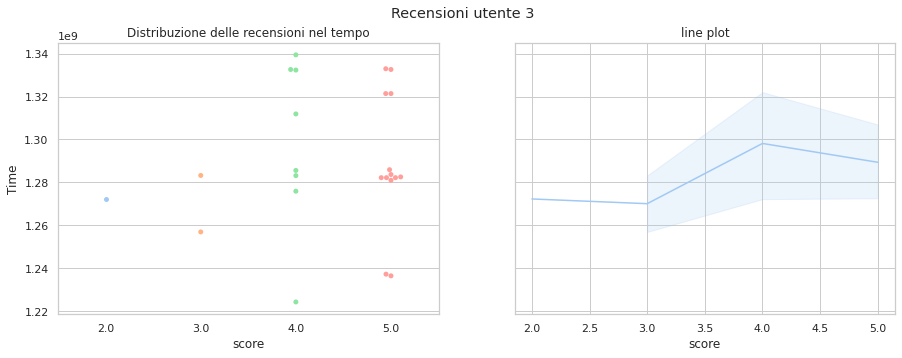

In [66]:
recap_user(user3, 3)

([<matplotlib.axis.YTick at 0x7fbd24e46198>,
 [Text(0, 0, '0'),
  Text(0, 0, '1'),
  Text(0, 0, '2'),
  Text(0, 0, '3'),
  Text(0, 0, '4'),
  Text(0, 0, '5')])

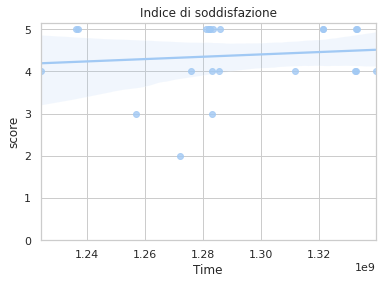

In [67]:
sns.regplot(data = user3, x='Time', y = 'score')
plt.title('Indice di soddisfazione')
plt.yticks(np.arange(6), labels=['0','1', '2', '3', '4', '5'])

Text(0.5, 1.0, 'Utilità delle recensioni')

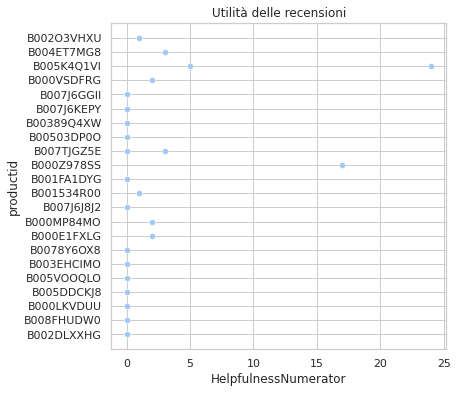

In [68]:
# utilità delle recensioni dell'utente 3
plt.figure(figsize=(6,6))
sns.scatterplot(data = user3, x = 'HelpfulnessNumerator', y='productid')
plt.title("Utilità delle recensioni")

In [69]:
strange = [user3[(user3.category_afinn != user3.category_score) | (user3.category_vader != user3.category_score)]]
strange

[        productid          userid  ... category_afinn  category_score
 369    B002O3VHXU  A3OXHLG6DIBRW8  ...              0               1
 813    B004ET7MG8  A3OXHLG6DIBRW8  ...              0              -1
 15792  B007TJGZ5E  A3OXHLG6DIBRW8  ...              0               1
 15819  B007TJGZ5E  A3OXHLG6DIBRW8  ...              0               1
 18508  B001FA1DYG  A3OXHLG6DIBRW8  ...              0               1
 20662  B000MP84MO  A3OXHLG6DIBRW8  ...              1               1
 27448  B003EHCIMO  A3OXHLG6DIBRW8  ...              0               1
 34074  B000LKVDUU  A3OXHLG6DIBRW8  ...              0               1
 34440  B008FHUDW0  A3OXHLG6DIBRW8  ...              0               1
 34934  B002DLXXHG  A3OXHLG6DIBRW8  ...              1               0
 
 [10 rows x 17 columns]]

In [70]:
user3['productid'].value_counts()

B005K4Q1VI    2
B007TJGZ5E    2
B007J6GGII    1
B007J6J8J2    1
B000LKVDUU    1
B002DLXXHG    1
B007J6KEPY    1
B008FHUDW0    1
B0078Y6OX8    1
B005DDCKJ8    1
B000MP84MO    1
B00389Q4XW    1
B000E1FXLG    1
B005VOOQLO    1
B000VSDFRG    1
B001534R00    1
B002O3VHXU    1
B004ET7MG8    1
B000Z978SS    1
B00503DP0O    1
B003EHCIMO    1
B001FA1DYG    1
Name: productid, dtype: int64

In [71]:
same_products = [user3[user3.productid == 'B005K4Q1VI']]
same_products[0]

,productid,userid,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,score,Summary,text,Time,neg,neu,pos,compound,afinn,category_vader,category_afinn,category_score
3306,B005K4Q1VI,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""",24,25,5.0,Really Good Hot Cocoa - Highly Recommended,These Grove Square Hot Cocoa flavors are by fa...,1321401600,0.0,0.810,0.190,0.9534,28.0,1,1,1
3416,B005K4Q1VI,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""",5,5,5.0,Really Good Hot Cocoa - Highly Recommended,These Grove Square Hot Cocoa flavors are by fa...,1321401600,0.0,0.807,0.193,0.9609,28.0,1,1,1


In [72]:
same_products = [user3[user3.productid == 'B007TJGZ5E']]
same_products[0]

,productid,userid,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,score,Summary,text,Time,neg,neu,pos,compound,afinn,category_vader,category_afinn,category_score
15792,B007TJGZ5E,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""",0,0,5.0,Very Smooth Coffee - Highly Recommended,"Green Mountain ""Nantucket Blend"" K-Cups make a...",1282176000,0.0,0.814,0.186,0.4927,3.0,0,0,1
15819,B007TJGZ5E,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""",3,3,5.0,Very Smooth Coffee - Highly Recommended,"Green Mountain ""Nantucket Blend"" K-Cups make a...",1282176000,0.0,0.814,0.186,0.4927,3.0,0,0,1


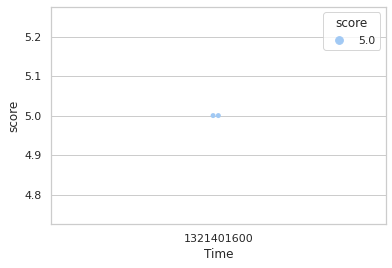

In [73]:
sns.swarmplot(data = user3[user3.productid == 'B005K4Q1VI'], x = 'Time', y = 'score', hue='score')

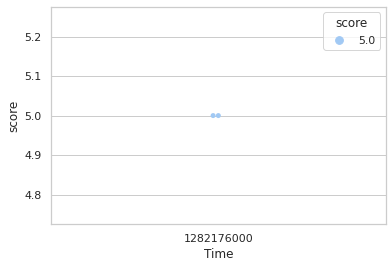

In [74]:
sns.swarmplot(data = user3[user3.productid == 'B007TJGZ5E'], x = 'Time', y = 'score', hue='score')

#Analysis on product

#### categorie di prodotti

In [75]:
df['categoria_prodotto'] = '/'
df.head(1)

,productid,userid,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,score,Summary,text,Time,neg,neu,pos,compound,afinn,category_vader,category_afinn,category_score,categoria_prodotto
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5.0,Good Quality Dog Food,I have bought several of the Vitality canned d...,1303862400,0.0,0.695,0.305,0.9441,16.0,1,1,1,/


In [76]:
df.categoria_prodotto = df.text.apply(lambda x: categoria_prodotto(x))
df.head(2)

,productid,userid,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,score,Summary,text,Time,neg,neu,pos,compound,afinn,category_vader,category_afinn,category_score,categoria_prodotto
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5.0,Good Quality Dog Food,I have bought several of the Vitality canned d...,1303862400,0.000,0.695,0.305,0.9441,16.0,1,1,1,Vitality
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1.0,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,1346976000,0.138,0.862,0.000,-0.5664,-2.0,-1,-1,-1,Jumbo


In [77]:
df.categoria_prodotto.value_counts()

coffee      2162
tea         1413
dog         1023
food         791
flavor       746
            ... 
cent-why       1
zoo            1
Mortimer       1
sticky.        1
Aribica        1
Name: categoria_prodotto, Length: 4789, dtype: int64

In [78]:
prodotti = df[(df['categoria_prodotto'] == 'coffee') | (df['categoria_prodotto'] =='tea') | (df['categoria_prodotto'] =='dog') | (df['categoria_prodotto'] =='taffy') | (df['categoria_prodotto'] =='toy')]
prodotti.head(2)

,productid,userid,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,score,Summary,text,Time,neg,neu,pos,compound,afinn,category_vader,category_afinn,category_score,categoria_prodotto
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5.0,Great taffy,Great taffy at a great price. There was a wid...,1350777600,0.0,0.552,0.448,0.9468,9.0,1,1,1,taffy
5,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4.0,Nice Taffy,I got a wild hair for taffy and ordered this f...,1342051200,0.0,0.856,0.144,0.4927,2.0,0,0,1,taffy


Text(0.5, 1.0, 'Categorie prodotti')

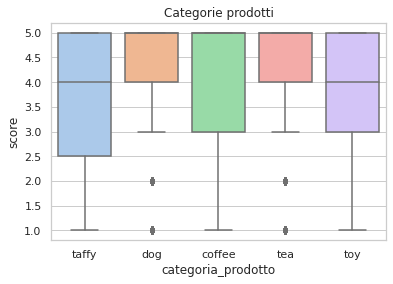

In [79]:
sns.boxplot(x="categoria_prodotto", y="score", data=prodotti)
plt.title('Categorie prodotti')

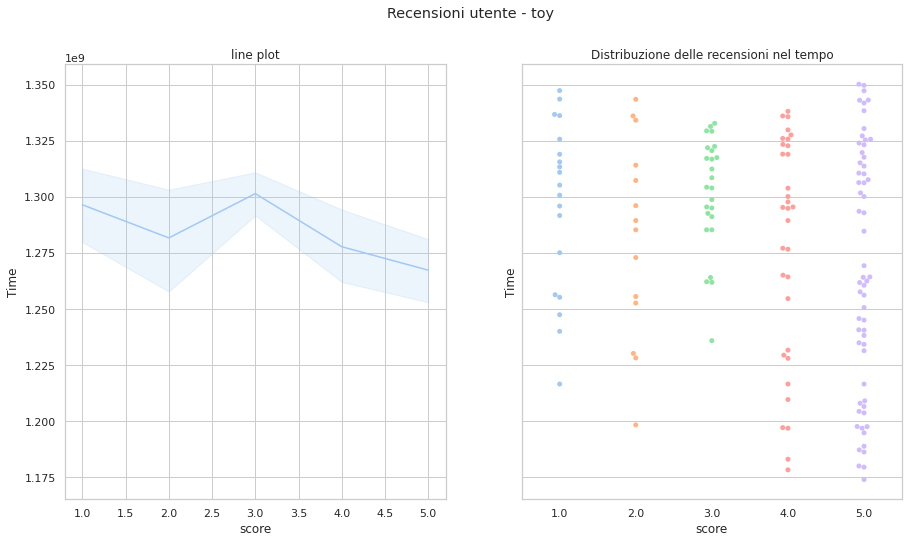

In [80]:
recap_categoria(prodotti[(prodotti['categoria_prodotto'] == 'toy')], 'toy')

([<matplotlib.axis.YTick at 0x7fdfe96258d0>,
 [Text(0, 0, '0'),
  Text(0, 0, '1'),
  Text(0, 0, '2'),
  Text(0, 0, '3'),
  Text(0, 0, '4'),
  Text(0, 0, '5')])

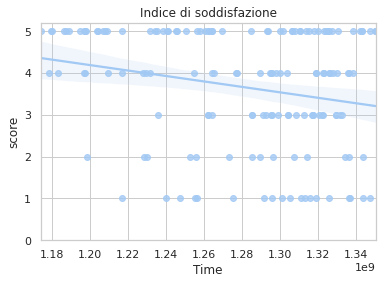

In [81]:
sns.regplot(data = prodotti[(prodotti['categoria_prodotto'] == 'toy')], x='Time', y = 'score')
plt.title('Indice di soddisfazione')
plt.yticks(np.arange(6), labels=['0','1', '2', '3', '4', '5'])
#plt.title("regplot")

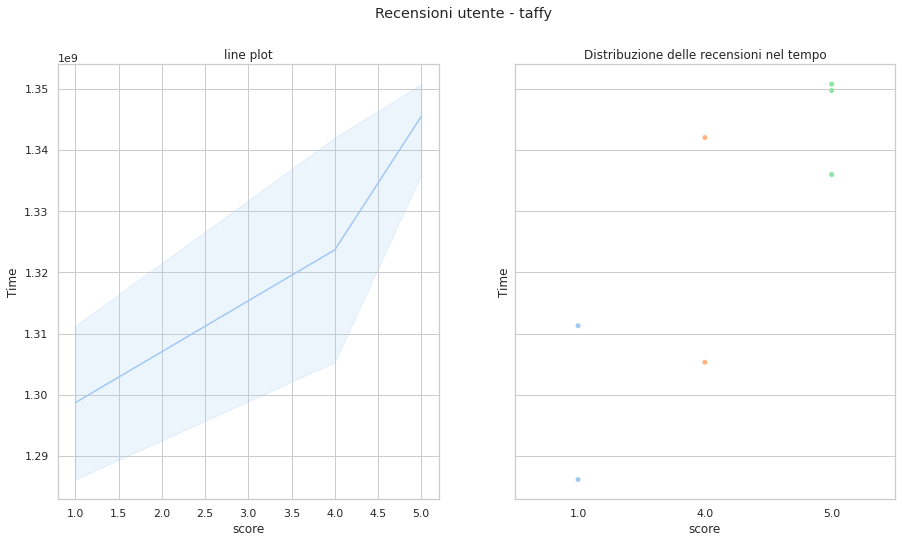

In [82]:
recap_categoria(prodotti[(prodotti['categoria_prodotto'] == 'taffy')], 'taffy')

([<matplotlib.axis.YTick at 0x7fdfe953b5f8>,
 [Text(0, 0, '0'),
  Text(0, 0, '1'),
  Text(0, 0, '2'),
  Text(0, 0, '3'),
  Text(0, 0, '4'),
  Text(0, 0, '5')])

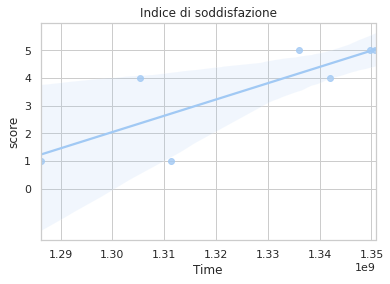

In [83]:
sns.regplot(data = prodotti[(prodotti['categoria_prodotto'] == 'taffy')], x='Time', y = 'score')
plt.title('Indice di soddisfazione')
plt.yticks(np.arange(6), labels=['0','1', '2', '3', '4', '5'])

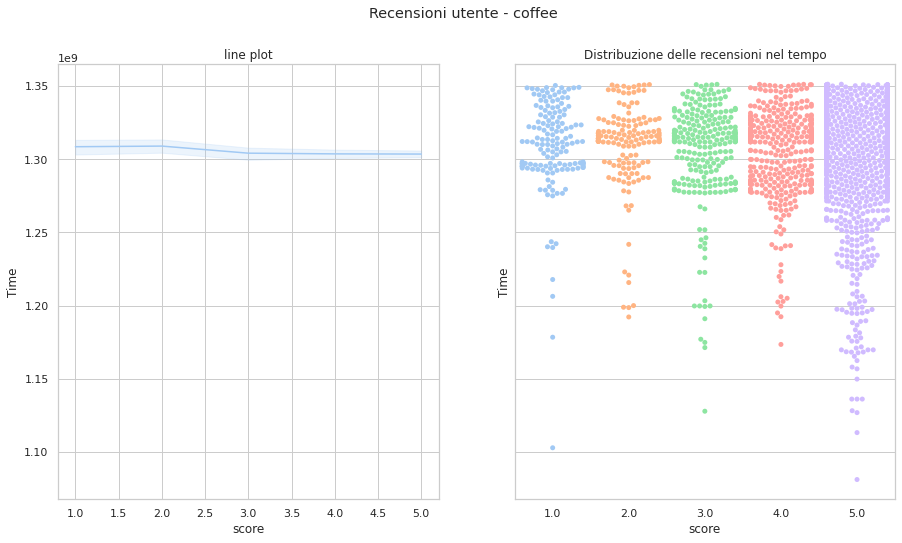

In [84]:
recap_categoria(prodotti[(prodotti['categoria_prodotto'] == 'coffee')], 'coffee')

([<matplotlib.axis.YTick at 0x7fdfe94314e0>,
 [Text(0, 0, '0'),
  Text(0, 0, '1'),
  Text(0, 0, '2'),
  Text(0, 0, '3'),
  Text(0, 0, '4'),
  Text(0, 0, '5')])

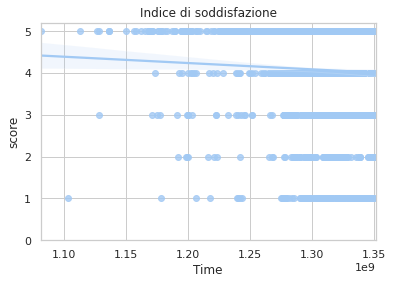

In [85]:
sns.regplot(data = prodotti[(prodotti['categoria_prodotto'] == 'coffee')], x='Time', y = 'score')
plt.title('Indice di soddisfazione')
plt.yticks(np.arange(6), labels=['0','1', '2', '3', '4', '5'])

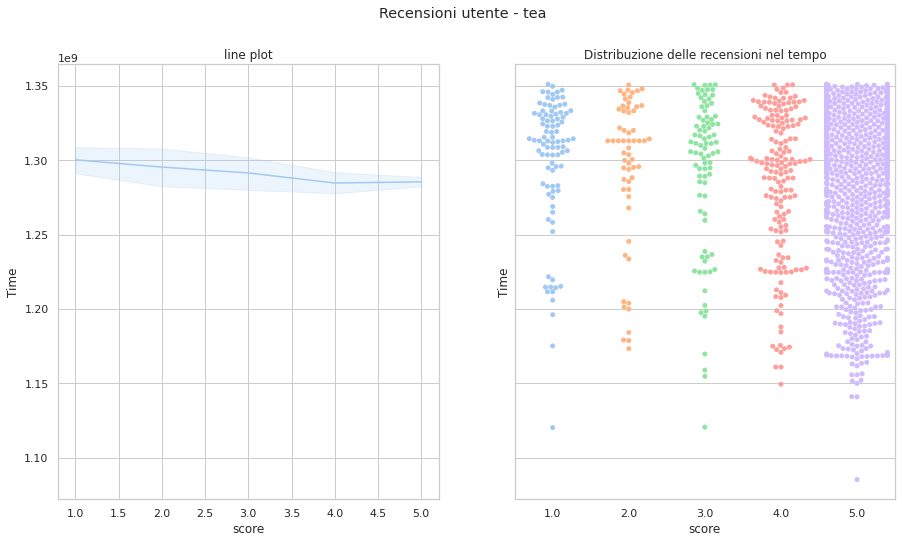

In [86]:
recap_categoria(prodotti[(prodotti['categoria_prodotto'] == 'tea')], 'tea')

([<matplotlib.axis.YTick at 0x7fdfe7b57e80>,
 [Text(0, 0, '0'),
  Text(0, 0, '1'),
  Text(0, 0, '2'),
  Text(0, 0, '3'),
  Text(0, 0, '4'),
  Text(0, 0, '5')])

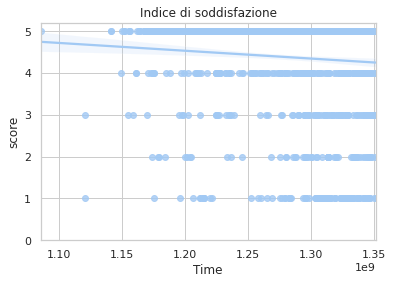

In [87]:
sns.regplot(data = prodotti[(prodotti['categoria_prodotto'] == 'tea')], x='Time', y = 'score')
plt.title('Indice di soddisfazione')
plt.yticks(np.arange(6), labels=['0','1', '2', '3', '4', '5'])

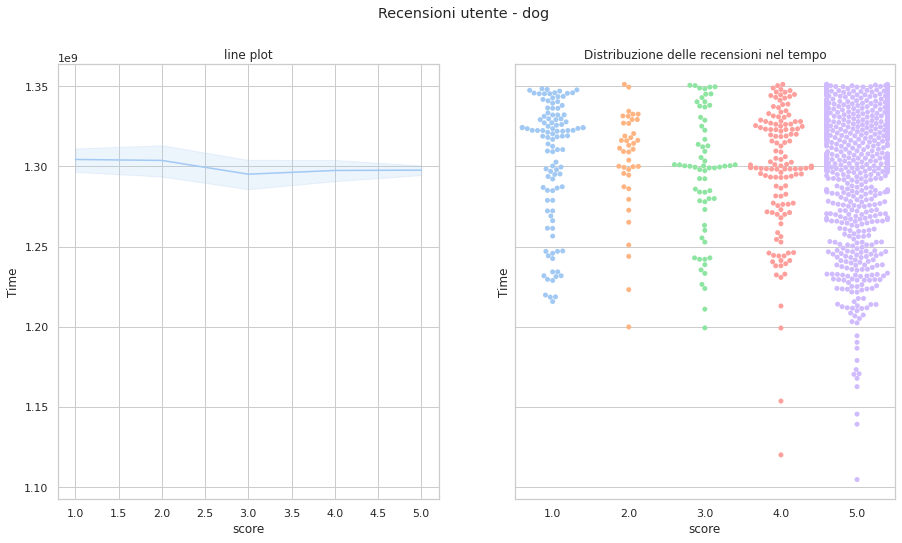

In [88]:
recap_categoria(prodotti[(prodotti['categoria_prodotto'] == 'dog')], 'dog')

([<matplotlib.axis.YTick at 0x7fdfe7a06cc0>,
 [Text(0, 0.5, '0'),
  Text(0, 1.0, '1'),
  Text(0, 1.5, '2'),
  Text(0, 2.0, '3'),
  Text(0, 2.5, '4'),
  Text(0, 3.0, '5')])

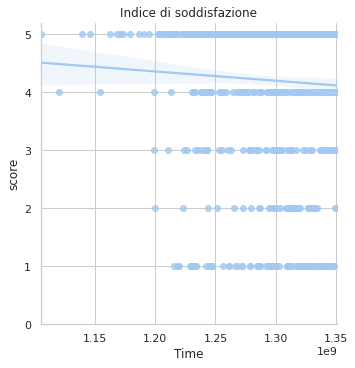

In [89]:
sns.lmplot(data = prodotti[(prodotti['categoria_prodotto'] == 'dog')], x='Time', y = 'score')
plt.title('Indice di soddisfazione')
plt.yticks(np.arange(6), labels=['0','1', '2', '3', '4', '5'])

### analisi prodotti singoli

In [90]:
df['productid'].value_counts()

B002QWP89S    632
B007M83302    564
B0013NUGDE    564
B000KV61FC    556
B000PDY3P0    487
             ... 
B004TDU1QC      1
B005CUK206      1
B00283LQR8      1
B00199CELE      1
B003TDRKHQ      1
Name: productid, Length: 4224, dtype: int64

#### first product

In [91]:
print(df[df.productid == "B002QWP89S"].categoria_prodotto.value_counts())

dog         145
price        21
treat        20
breath       19
Greenies     18
           ... 
reward        1
pitbull       1
Super         1
rawhide       1
Oliver        1
Name: categoria_prodotto, Length: 252, dtype: int64


In [92]:
df[df.productid == "B002QWP89S"].score.value_counts()

5.0    498
4.0     74
1.0     27
3.0     21
2.0     12
Name: score, dtype: int64

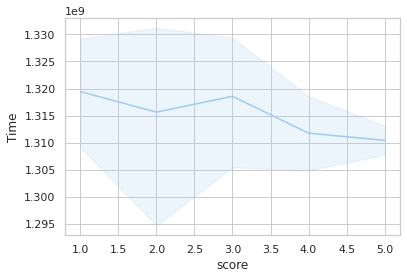

In [93]:
sns.lineplot(y="Time", x="score", data=df[df.productid == "B002QWP89S"])

([<matplotlib.axis.YTick at 0x7fdfe78ea438>,
 [Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3'),
  Text(0, 4.0, '4'),
  Text(0, 5.0, '5')])

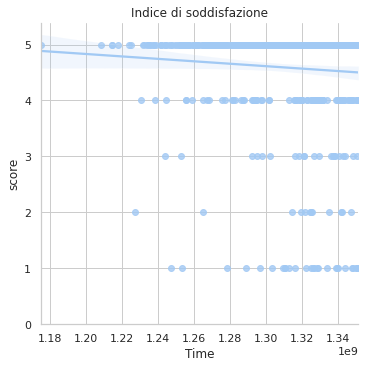

In [94]:
sns.lmplot(data=df[df.productid == "B002QWP89S"], x='Time', y = 'score')
plt.title('Indice di soddisfazione')
plt.yticks(np.arange(6), labels=['0','1', '2', '3', '4', '5'])

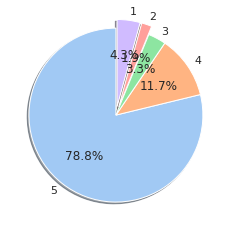

In [95]:
pie_plot_prod(df,"B002QWP89S")

In [96]:
df[df.productid == "B002QWP89S"].userid.value_counts()

AA5D2Q1O4ZMG8     3
AVTY5M74VA1BJ     3
A2974R9BTPZPOJ    2
A25OE2QSYV6J38    2
A1UGRR7QI5TGAF    2
                 ..
AKWP7LOOOF3NB     1
A235E6VS81NY52    1
A2LTQKVUG75IW9    1
A22GALIXAEXTL8    1
A2D3XOW2VKD9G0    1
Name: userid, Length: 609, dtype: int64

In [97]:
df[(df.productid == "B002QWP89S") & (df.userid == "AVTY5M74VA1BJ")]

,productid,userid,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,score,Summary,text,Time,neg,neu,pos,compound,afinn,category_vader,category_afinn,category_score,categoria_prodotto
20985,B002QWP89S,AVTY5M74VA1BJ,tarotqueen,1,1,5.0,dogs love greenies,"What can I say, dogs love greenies. They begg ...",1316822400,0.0,0.840,0.160,0.6369,3.0,1,0,1,time
21312,B002QWP89S,AVTY5M74VA1BJ,tarotqueen,0,0,5.0,dogs love greenies,Dogs love these things. they sit around the cu...,1316822400,0.0,0.609,0.391,0.9112,8.0,1,1,1,cupboard
21314,B002QWP89S,AVTY5M74VA1BJ,tarotqueen,0,0,5.0,dogs love greenies,My dogs love these things. They would eat the ...,1316736000,0.0,0.870,0.130,0.6369,3.0,1,0,1,box


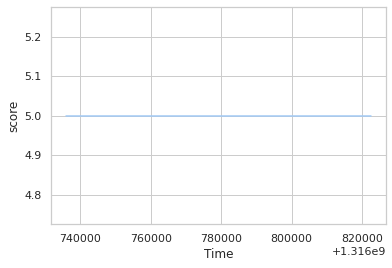

In [98]:
sns.lineplot(x="Time", y="score", data=df[(df.productid == "B002QWP89S") & (df.userid == "AVTY5M74VA1BJ")])

In [99]:
product = df[(df.productid == "B002QWP89S") & (df.userid == "AA5D2Q1O4ZMG8")]
product
# cose straneee

,productid,userid,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,score,Summary,text,Time,neg,neu,pos,compound,afinn,category_vader,category_afinn,category_score,categoria_prodotto
21122,B002QWP89S,AA5D2Q1O4ZMG8,D. Morris,0,0,5.0,Dog's love them,"I order these constantly for my dogs, and my r...",1342310400,0.000,1.000,0.000,0.0000,0.0,0,0,1,order
21223,B002QWP89S,AA5D2Q1O4ZMG8,D. Morris,0,0,5.0,My Dogs Go Crazy for These Greenies,I buy the lite teenies for my two little dogs ...,1328313600,0.000,1.000,0.000,0.0000,0.0,0,0,1,anything
21596,B002QWP89S,AA5D2Q1O4ZMG8,D. Morris,1,1,5.0,My dogs go crazy for these,"Heaven forbid that I should run out of these, ...",1326153600,0.043,0.809,0.148,0.9541,10.0,1,1,1,greenie


#### second product

In [100]:
print(df[df.productid == "B007M83302"].categoria_prodotto.value_counts())

flavor      45
bag         35
potato      33
taste       20
chip        19
            ..
oz           1
WW           1
MSG          1
barbeque     1
sea          1
Name: categoria_prodotto, Length: 203, dtype: int64


In [101]:
df[df.productid == "B007M83302"].score.value_counts()

5.0    369
4.0     90
3.0     46
1.0     30
2.0     29
Name: score, dtype: int64

([<matplotlib.axis.YTick at 0x7fdfe780bac8>,
 [Text(0, 0.5, '0'),
  Text(0, 1.0, '1'),
  Text(0, 1.5, '2'),
  Text(0, 2.0, '3'),
  Text(0, 2.5, '4'),
  Text(0, 3.0, '5')])

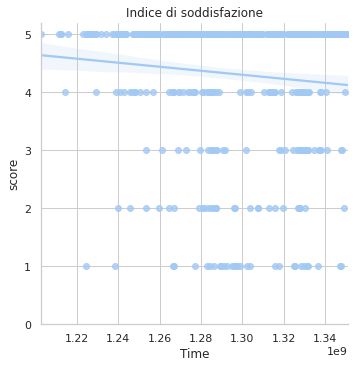

In [102]:
sns.lmplot(data=df[df.productid == "B007M83302"], x='Time', y = 'score')
plt.title('Indice di soddisfazione')
plt.yticks(np.arange(6), labels=['0','1', '2', '3', '4', '5'])

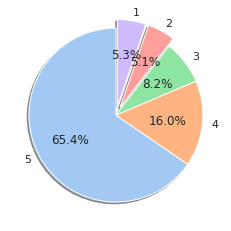

In [103]:
pie_plot_prod(df,"B007M83302")

In [104]:
df[df.productid == "B007M83302"].userid.value_counts()

A1LTNRGWZFY4C9    5
A3A1OA237FOZFK    3
A2GSNLOLNOZWMM    2
AOB4R397Z9F5C     2
AXXWXM6K66YMZ     2
                 ..
A3KUBHNQVJNBMQ    1
A1B3ZEHM44FVUC    1
A1DNXL8BIR5R8R    1
AVBYIVT620ZL5     1
A1B4T1Z4TJZUSX    1
Name: userid, Length: 551, dtype: int64

In [105]:
product2 = df[(df.productid == "B007M83302") & (df.userid == "A1LTNRGWZFY4C9")]
product2

# inizio testo molto simile

,productid,userid,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,score,Summary,text,Time,neg,neu,pos,compound,afinn,category_vader,category_afinn,category_score,categoria_prodotto
30750,B007M83302,A1LTNRGWZFY4C9,GROUCHHUNTER,1,1,5.0,LOVE THE POPCHIPS!,I am totally addicted to the POPCHIPS! They a...,1253232000,0.091,0.792,0.117,0.2607,17.0,0,1,1,POPCHIPS
30911,B007M83302,A1LTNRGWZFY4C9,GROUCHHUNTER,3,3,5.0,Cheddar POPCHIPS are totally Yummy!,I am addicted to Popchips - I love the cheddar...,1253318400,0.000,0.855,0.145,0.8689,7.0,1,1,1,bag
31095,B007M83302,A1LTNRGWZFY4C9,GROUCHHUNTER,0,0,5.0,BBQ POPCHIP HEAVEN,Wow - I am totally addicted to these. In my o...,1253318400,0.018,0.777,0.205,0.9677,21.0,1,1,1,Wow
31097,B007M83302,A1LTNRGWZFY4C9,GROUCHHUNTER,0,0,3.0,TOTALLY LOVE POPCHIPS!,I am totally addicted to POPCHIPS! This is a ...,1253232000,0.052,0.765,0.183,0.8406,7.0,1,1,0,flavor
31098,B007M83302,A1LTNRGWZFY4C9,GROUCHHUNTER,0,0,2.0,Way too much Vinegar for me,I totally love POPCHIPS - but the Sea Salt and...,1253232000,0.000,0.812,0.188,0.8499,7.0,1,1,-1,Vinegar


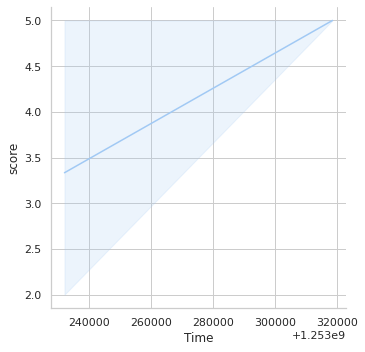

In [106]:
sns.relplot(data = product2, x = 'Time', y = 'score', kind='line')

In [107]:
print(product2.loc[30750].text)
print(product2.loc[31097].text)
print(product2.loc[31098].text)

I am totally addicted to the POPCHIPS!  They are very good and don't taste greasy at all.  One bag has a lot of chips in them and can be filling.  They are only 100 calories and around 3 grams of fat and they don't taste like you are eating something healthy for you.  I love Cheetos and can't have them anymore and now love these chips.  The flavoring is not very strong but strong enough.
I am totally addicted to POPCHIPS!  This is a very plain flavor, but tasts ok - it is not my favorite but I can eat them.  It tates better than a plain chip - not greasy or anything.  Around 100 calories and 3 grams of fat is still a very good snack, in my opinion.  I would buy these again.
I totally love POPCHIPS - but the Sea Salt and Vinegar just has too much Vinegar taste for me.  I felt like I was eating just vinegar.  I took the rest to work and some people like the flavor and some said just to much vinegar for them.


#### prodotto peggiore

In [108]:
peggiore = df[df['score']<=2]
peggiore['productid'].value_counts()

B000KV61FC    167
B006N3IG4K     81
B003VXFK44     81
B001AJ1ULS     70
B004ZIER34     70
             ... 
B000NPZUBG      1
B003BLD6PG      1
B0018AMWLG      1
B006LGW672      1
B005H8E1F0      1
Name: productid, Length: 1557, dtype: int64

In [109]:
print(peggiore.categoria_prodotto.value_counts())

coffee     301
tea        152
dog        147
taste      136
flavor     118
          ... 
tongue       1
Formula      1
vomit        1
home         1
Lowery       1
Name: categoria_prodotto, Length: 1457, dtype: int64


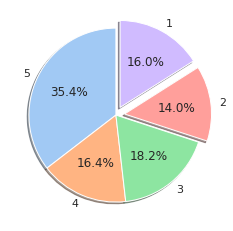

In [110]:
pie_plot_prod(df,"B000KV61FC")

([<matplotlib.axis.YTick at 0x7fdfebd2a9e8>,
 [Text(0, 0.5, '0'),
  Text(0, 1.0, '1'),
  Text(0, 1.5, '2'),
  Text(0, 2.0, '3'),
  Text(0, 2.5, '4'),
  Text(0, 3.0, '5')])

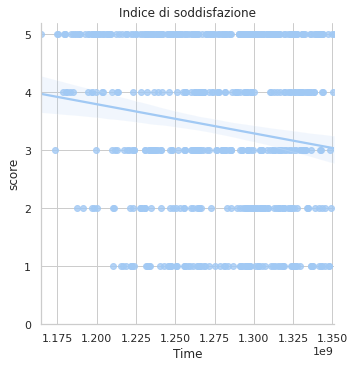

In [111]:
sns.lmplot(data=df[df['productid'] == "B000KV61FC"], x='Time', y = 'score')
plt.title('Indice di soddisfazione')
plt.yticks(np.arange(6), labels=['0','1', '2', '3', '4', '5'])

In [112]:
product3 = peggiore[peggiore['productid'] == "B000KV61FC"]
product3

,productid,userid,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,score,Summary,text,Time,neg,neu,pos,compound,afinn,category_vader,category_afinn,category_score,categoria_prodotto
21738,B000KV61FC,A1SLLKDKCZ5IPL,C. Guariglia,2,2,2.0,Buried Treasure Forever!,"The idea is basically a good one, however, my ...",1221091200,0.021,0.858,0.122,0.6005,4.0,1,1,-1,idea
21746,B000KV61FC,A20QJV2J5WE8WF,Katherine,4,5,1.0,Awful! Didn't make it through a day!,"<span class=""tiny""> Length",1258156800,0.000,1.000,0.000,0.0000,0.0,0,0,-1,span
21747,B000KV61FC,APZ4513FCAXKG,D. Sesma,4,5,1.0,Weak,"My dog chewed the rope in half first, then che...",1215734400,0.169,0.831,0.000,-0.8456,1.0,-1,0,-1,dog
21748,B000KV61FC,AEU40RYOIEKFV,ChiNovice,1,1,1.0,ATTENTION: This toy is DANGEROUS for your dog!,Our dog chewed through ate the vanilla infused...,1345248000,0.063,0.861,0.075,0.2500,-5.0,0,-1,-1,dog
21782,B000KV61FC,A14MIVRKSKNP4F,Robert (murphy_r@hotmail.com),1,1,2.0,Lids break easily,"Dogs loved it but, 3 out of 3 I purchased had ...",1319414400,0.000,0.843,0.157,0.4404,3.0,0,0,-1,crack
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22242,B000KV61FC,A20ZO8UFW5EFS6,A. Gift for You,1,4,1.0,WASTE OF MONEY,I BOUGHT THIS FOR MY DOG AND HE TOOK ONE LOOK ...,1233273600,0.119,0.824,0.057,-0.3935,-1.0,0,-1,-1,IT
22256,B000KV61FC,A1XS1BJ87Z5LYT,CJ,2,2,1.0,great concept; miserable construction,I had this for 2 days before my dog rolled it ...,1312502400,0.088,0.912,0.000,-0.4767,-4.0,0,-1,-1,dog
22257,B000KV61FC,A3390PG4BAU78C,"Beth-Ann Mason ""Beth-Ann M.""",2,2,1.0,Definitely not a Kong....,The package says that this is supposed to be p...,1307232000,0.029,0.873,0.098,0.9130,4.0,1,1,-1,chewer
22260,B000KV61FC,A3BKTC9RCMFUTJ,"C Anderson ""C Anderson""",2,2,1.0,Broke On the 4th Day of Use :(,"Last night, I visited a friend who had bought ...",1300838400,0.047,0.848,0.105,0.8751,6.0,1,1,-1,toy


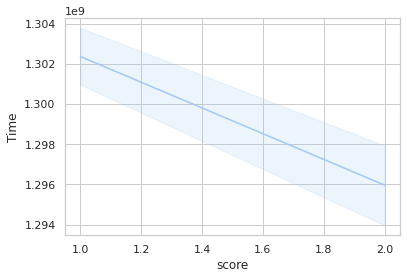

In [113]:
sns.lineplot(y="Time", x="score", data=peggiore)

In [114]:
product3['userid'].value_counts()

A3CY8OJOSU8727    1
A23FG04WAXU8WQ    1
AK68SCHF3779J     1
A1JL5ZJYDBNY9V    1
A2T89T26FO5Q8J    1
                 ..
AJNJI8L53U59F     1
A3GFYT7MA757B9    1
A2L11XFJ1W0AV1    1
AVBR6EYD2CVYP     1
A3390PG4BAU78C    1
Name: userid, Length: 167, dtype: int64

#### utente che ha recensito spesso con voti bassi

In [115]:
peggiore['userid'].value_counts()

AF3BYMPWKWO8F     9
A2NLZ3M0OJV9NX    8
A37Y0WULUM9IJ5    6
AKZKG2Z7CNV27     6
A2TN9C5E4A0I3F    5
                 ..
A23S3T8I6TAJOL    1
A3AIIFXEEHKQWX    1
AUJLESX4LT8NQ     1
A2DPXEK3B5ZOSG    1
A2WOB6TD0DHM23    1
Name: userid, Length: 4703, dtype: int64

In [116]:
user4 = df[(df.userid == "AF3BYMPWKWO8F")]
user4

# strano

,productid,userid,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,score,Summary,text,Time,neg,neu,pos,compound,afinn,category_vader,category_afinn,category_score,categoria_prodotto
4584,B002TMV3E4,AF3BYMPWKWO8F,Joe MacBu,0,3,2.0,Meh,The initial aroma upon opening the package was...,1290038400,0.086,0.836,0.078,-0.1779,-3.0,0,-1,-1,coffee
20268,B001BDDTB2,AF3BYMPWKWO8F,Joe MacBu,0,0,1.0,Warning: Contains Menadione,"According to the manufacturer's website, this ...",1229558400,0.083,0.874,0.043,-0.8176,-9.0,-1,-1,-1,food
20343,B001BDDTB2,AF3BYMPWKWO8F,Joe MacBu,91,98,3.0,Please check the controversial ingredients and...,While several reviewers have alluded to the he...,1227571200,0.034,0.877,0.089,0.7615,1.0,1,0,0,healthfulness
20345,B001BDDTB2,AF3BYMPWKWO8F,Joe MacBu,20,23,1.0,Warning: Contains Menadione,"According to the manufacturer's website, this ...",1243555200,0.083,0.874,0.043,-0.8176,-9.0,-1,-1,-1,food
20347,B001BDDTB2,AF3BYMPWKWO8F,Joe MacBu,6,6,1.0,Warning: Contains Menadione,"According to the manufacturer's website, this ...",1229558400,0.083,0.874,0.043,-0.8176,-9.0,-1,-1,-1,food
20350,B001BDDTB2,AF3BYMPWKWO8F,Joe MacBu,7,8,1.0,Warning: Contains Menadione,"According to the manufacturer's website, this ...",1243555200,0.083,0.874,0.043,-0.8176,-9.0,-1,-1,-1,food
20376,B001BDDTB2,AF3BYMPWKWO8F,Joe MacBu,0,1,1.0,Warning: Contains Menadione,"According to the manufacturer's website, this ...",1243555200,0.083,0.874,0.043,-0.8176,-9.0,-1,-1,-1,food
20411,B001BDDTB2,AF3BYMPWKWO8F,Joe MacBu,6,7,1.0,Warning: Contains Menadione,"According to the manufacturer's website, this ...",1229558400,0.083,0.874,0.043,-0.8176,-9.0,-1,-1,-1,food
20415,B001BDDTB2,AF3BYMPWKWO8F,Joe MacBu,3,3,1.0,Warning: Contains Menadione,"According to the manufacturer's website, this ...",1243555200,0.083,0.874,0.043,-0.8176,-9.0,-1,-1,-1,food
20416,B001BDDTB2,AF3BYMPWKWO8F,Joe MacBu,3,3,1.0,Warning: Contains Menadione,"According to the manufacturer's website, this ...",1243555200,0.083,0.874,0.043,-0.8176,-9.0,-1,-1,-1,food


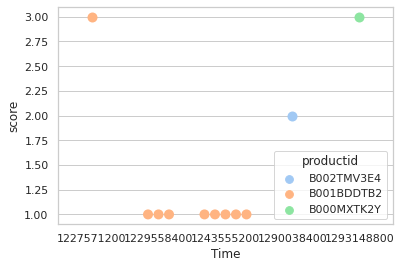

In [117]:
sns.swarmplot(x="Time", y="score",hue='productid', size= 10, data=df[(df.userid == "AF3BYMPWKWO8F")])

In [118]:
print(user4['text'].loc[20345] == user4['text'].loc[20415])

True


#Analysis on text 

In [119]:
df['text'].value_counts()

<a href="http                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [120]:
df[df.text == "Diamond Almonds<br />Almonds are a good source of magnesium. One ounce contain approximately 20% of the RDA for an adult recommended dietary allowance (RDA)<br />Recommended Dietary Allowance (RDA) the amounts of selected nutrients considered adequate to meet the known nutrient needs of healthy people. The RDA is based on scientific knowledge and has been presented by a committee of the Food and Nutrition Board (FNB) of the National Academy of Sciences (NAS). The Canadian equivalent is the Recommended Nutrient Intakes. RDA is generally accepted throughout the world as a valid source of information. At least 40 different nations have as well as organizations have published standards similar to the RDA.<br /><br />Magnesium is the fourth most abundant mineral in the body and is essential to good health. Approximately 50% of total body magnesium is found in bone. The other half is found predominantly inside cells of body tissues and organs. Only 1% of magnesium is found in blood, but the body works very hard to keep blood levels of magnesium constant.<br />Magnesium is needed for more than 300 biochemical reactions in the body. It helps maintain normal muscle and nerve function, keeps heart rhythm steady, supports a healthy immune system, and keeps bones strong. Magnesium also helps regulate blood sugar levels, promotes normal blood pressure, and is known to be involved in energy metabolism and protein synthesis. There is an increased interest in the role of magnesium in preventing and managing disorders such as hypertension, cardiovascular disease, and diabetes. Dietary magnesium is absorbed in the small intestines. Are you taking enough magnesium in the diet? The recommended daily allowance is 300mgs/day for men, 350mgs for women. Magnesium is extremely safe by mouth - too much simply causes diarrhea. Try increasing the amount of magnesium you take by mouth until it causes diarrhea, then reduce the dose slightly so it does not. This is called taking magnesium to bowel tolerance (just like using vitamin C to bowel tolerance.<br /><br />Almonds are a good source of Fiber.<br />One ounce contains approximately 12% of the RDA for an adult.<br />So, in summary, Almonds are a very healthy snack, so what's left to say?<br /><br />Two things"]

,productid,userid,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,score,Summary,text,Time,neg,neu,pos,compound,afinn,category_vader,category_afinn,category_score,categoria_prodotto
10836,B0034KP00S,A1TMAVN4CEM8U8,Gunner,1,1,5.0,My 3rd favorite flavor,Diamond Almonds<br />Almonds are a good source...,1331251200,0.015,0.809,0.176,0.9958,41.0,1,1,1,magnesium
10860,B0034KP00S,A1TMAVN4CEM8U8,Gunner,0,0,5.0,My 3rd favorite flavor,Diamond Almonds<br />Almonds are a good source...,1332115200,0.015,0.809,0.176,0.9958,41.0,1,1,1,magnesium
10861,B0034KP00S,A1TMAVN4CEM8U8,Gunner,0,0,5.0,My favorite flavor bar none,Diamond Almonds<br />Almonds are a good source...,1332115200,0.015,0.809,0.176,0.9958,41.0,1,1,1,magnesium
10862,B0034KP00S,A1TMAVN4CEM8U8,Gunner,0,0,5.0,My 3rd favorite flavor,Diamond Almonds<br />Almonds are a good source...,1332028800,0.015,0.809,0.176,0.9958,41.0,1,1,1,magnesium
10884,B0034KP00S,A1TMAVN4CEM8U8,Gunner,0,1,5.0,I prefer the flavored,Diamond Almonds<br />Almonds are a good source...,1336348800,0.015,0.809,0.176,0.9958,41.0,1,1,1,magnesium
11237,B001KVPC0G,A1TMAVN4CEM8U8,Gunner,0,1,5.0,I prefer the flavored,Diamond Almonds<br />Almonds are a good source...,1332288000,0.015,0.809,0.176,0.9958,41.0,1,1,1,magnesium
11238,B001KVPC0G,A1TMAVN4CEM8U8,Gunner,0,1,5.0,I prefer the flavored,Diamond Almonds<br />Almonds are a good source...,1331942400,0.015,0.809,0.176,0.9958,41.0,1,1,1,magnesium
25447,B0051TPWUI,A1TMAVN4CEM8U8,Gunner,1,1,5.0,My 3rd favorite flavor,Diamond Almonds<br />Almonds are a good source...,1331251200,0.015,0.809,0.176,0.9958,41.0,1,1,1,magnesium
25471,B0051TPWUI,A1TMAVN4CEM8U8,Gunner,0,0,5.0,My 3rd favorite flavor,Diamond Almonds<br />Almonds are a good source...,1332115200,0.015,0.809,0.176,0.9958,41.0,1,1,1,magnesium
25472,B0051TPWUI,A1TMAVN4CEM8U8,Gunner,0,0,5.0,My favorite flavor bar none,Diamond Almonds<br />Almonds are a good source...,1332115200,0.015,0.809,0.176,0.9958,41.0,1,1,1,magnesium


In [121]:
df[df.text == '<span class="tiny"> Length']

,productid,userid,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,score,Summary,text,Time,neg,neu,pos,compound,afinn,category_vader,category_afinn,category_score,categoria_prodotto
158,B000ITVLE2,A3NID9D9WMIV01,"Louie Arrighi ""Lou da Joo""",17,19,5.0,tastes very fresh,"<span class=""tiny""> Length",1260057600,0.0,1.0,0.0,0.0,0.0,0,0,1,span
1460,B0040WHJQM,A3NID9D9WMIV01,"Louie Arrighi ""Lou da Joo""",16,18,5.0,why is this soup/entree so unpopular????,"<span class=""tiny""> Length",1304467200,0.0,1.0,0.0,0.0,0.0,0,0,1,span
2378,B00196U7OI,A251MRI34QYHH2,Suzanne Estrada,0,0,5.0,Best Healthy Cookie I've Ever Tasted!! Pretty ...,"<span class=""tiny""> Length",1271808000,0.0,1.0,0.0,0.0,0.0,0,0,1,span
5487,B00622CYVI,A1KF5OLL7AZ3Q,stacey,0,1,5.0,How to keep the jars from breaking,"<span class=""tiny""> Length",1295308800,0.0,1.0,0.0,0.0,0.0,0,0,1,span
6755,B001LG945O,A3HRDRQ5VAFPQS,"P. Falcioni ""Ducatisti""",0,0,3.0,"Good flavor, small serving, high in calories","<span class=""tiny""> Length",1236038400,0.0,1.0,0.0,0.0,0.0,0,0,0,span
11688,B0032RPLSY,AY430JLATCN6R,zitcat,0,0,4.0,"Superb Quality, Delicious Ghee","<span class=""tiny""> Length",1351036800,0.0,1.0,0.0,0.0,0.0,0,0,1,span
11691,B0032RPLSY,A2TLJAFTT5KZJX,sean Coonce,0,0,5.0,Pure Indian Foods Grass Fed Ghee,"<span class=""tiny""> Length",1350518400,0.0,1.0,0.0,0.0,0.0,0,0,1,span
11692,B0032RPLSY,A1C1LJIAQNRL2H,S. Robertson,0,0,5.0,Best Ghee on the planet,"<span class=""tiny""> Length",1350432000,0.0,1.0,0.0,0.0,0.0,0,0,1,span
11803,B004P4TL8E,A2LSBXARAF7OOX,W. Bookhultz,47,51,4.0,Nice Design but beware of clearance space,"<span class=""tiny""> Length",1308614400,0.0,1.0,0.0,0.0,0.0,0,0,1,span
14064,B0045XE32E,A261Q5U692JF17,"BeachBrights ""beachbrights blogspot""",2,4,5.0,Even my cat liked them!,"<span class=""tiny""> Length",1298851200,0.0,1.0,0.0,0.0,0.0,0,0,1,span


In [122]:
df[(df.text == 'pros') | (df.text == 'Pros')]

,productid,userid,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,score,Summary,text,Time,neg,neu,pos,compound,afinn,category_vader,category_afinn,category_score,categoria_prodotto
196,B0028C44Z0,AI7O5C9KBVSTF,i&#60;3pnutbutter,3,4,5.0,Altoids Smalls-Wintergreen,Pros,1274054400,0.0,1.0,0.0,0.0,0.0,0,0,1,None
642,B001EPPFGO,A4RC31AVN5LWJ,"Zoran Dzeletovic ""dzela""",0,0,5.0,Best Earl Grey ever,Pros,1309910400,0.0,1.0,0.0,0.0,0.0,0,0,1,None
4096,B001EW5YQS,A1P202BHNDDVWD,BP Foto,1,1,4.0,"Could be better, but it works and it's inexpen...",Pros,1276214400,0.0,1.0,0.0,0.0,0.0,0,0,1,None
4966,B001DW2RGO,A2T4GSH2H928ME,Bank Of America,4,9,5.0,energy shots that works !!,Pros,1277510400,0.0,1.0,0.0,0.0,0.0,0,0,1,None
5695,B00434J6YK,ATM0FEJBT1XIX,Earth Watcher,0,0,3.0,"Tasty and no wheat, but contain soy and palm a...",Pros,1329523200,0.0,1.0,0.0,0.0,0.0,0,0,0,None
6853,B001LG945O,A27UE9HJRZ22YI,"Louie's Mom ""Compulsive Reader""",2,4,2.0,"I had high hopes, am a bit disappointed",Pros,1245801600,0.0,1.0,0.0,0.0,0.0,0,0,-1,None
10485,B0016J7SYU,A2FO9RWN3IW65I,"JP ""JP""",0,0,5.0,Excellent Organic Granola Cereal for All,Pros,1290124800,0.0,1.0,0.0,0.0,0.0,0,0,1,None
11877,B004P4TL8E,AK6U9LTNTR8OI,Ian Vaughan,0,0,4.0,"Space saver, be careful if your coffee maker i...",Pros,1324339200,0.0,1.0,0.0,0.0,0.0,0,0,1,None
15499,B000255OIG,A32TR272T1PFE1,Mr. Gibbs,0,0,5.0,Awesome!,Pros,1296864000,0.0,1.0,0.0,0.0,0.0,0,0,1,None
16676,B001LGGH40,ATZPI8XK3KP7,Ikihi,0,0,3.0,didn't like it,pros,1238198400,0.0,1.0,0.0,0.0,0.0,0,0,0,None


#### Pulizia del dataset

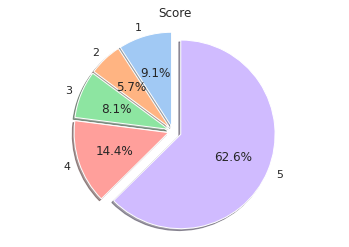

In [123]:
gr = df.groupby('score')
uno = gr.get_group(1).count().score
due = gr.get_group(2).count().score
tre = gr.get_group(3).count().score
quattro = gr.get_group(4).count().score
cinque = gr.get_group(5).count().score

size = [uno,due,tre,quattro,cinque]

labels = ['1', '2', '3','4','5']
explode = (0.05, 0.05,0.05,0.05,0.09) 

fig1, ax1 = plt.subplots()
ax1.pie(size, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Score')
plt.show()

In [124]:
# elimino i test uguali perchè li ritengo dei bot o insensati

print(df.text.count())
df = df.drop_duplicates(subset=['text'])
print(df.text.count())

35172
32872


In [125]:
# data cleaning 

df = df.drop(df[(df.score >= 5) & ((df.category_afinn <= 0) | (df.category_vader <= 0))].index)
print(df.text.count())

27767


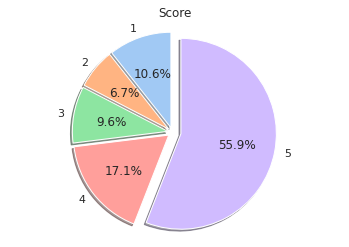

In [126]:
gr = df.groupby('score')
uno = gr.get_group(1).count().score
due = gr.get_group(2).count().score
tre = gr.get_group(3).count().score
quattro = gr.get_group(4).count().score
cinque = gr.get_group(5).count().score

size = [uno,due,tre,quattro,cinque]

labels = ['1', '2', '3','4','5']
explode = (0.05, 0.05,0.05,0.05,0.09) 

fig1, ax1 = plt.subplots()
ax1.pie(size, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Score')
plt.show()

# Preprocessing

## data augmentation

https://arxiv.org/abs/2007.12229

https://www.kaggle.com/theoviel/using-word-embeddings-for-data-augmentation

https://towardsdatascience.com/data-augmentation-library-for-text-9661736b13ff

https://github.com/makcedward/nlpaug/blob/master/example/textual_augmenter.ipynb

In [ ]:
def textaug(text):
  aug = naw.SynonymAug(aug_src='wordnet')
  text = aug.augment(text, n=1)
  return text

In [ ]:
def augdf(df):
  augdf = df[df.category_score < 1]        
  augdf.text = augdf['text'].apply(lambda x: textaug(x))
  return augdf

> concat df and augdf

In [ ]:
df = pd.concat([df, augdf(df), augdf(df)])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


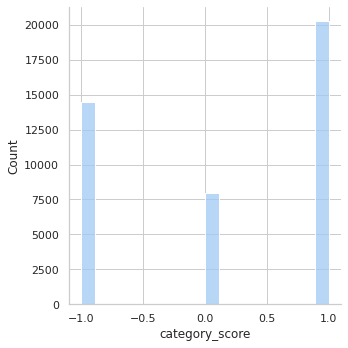

In [ ]:
sns.displot(df['category_score'], facet_kws=dict(margin_titles=True))

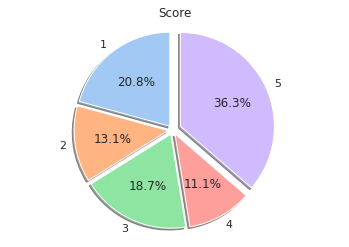

In [ ]:
gr = df.groupby('score')
uno = gr.get_group(1).count().score
due = gr.get_group(2).count().score
tre = gr.get_group(3).count().score
quattro = gr.get_group(4).count().score
cinque = gr.get_group(5).count().score

size = [uno,due,tre,quattro,cinque]

labels = ['1', '2', '3','4','5']
explode = (0.05, 0.05,0.05,0.05,0.09) 

fig1, ax1 = plt.subplots()
ax1.pie(size, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Score')
plt.show()

## Text preprocessing 






> tokenaized test

> revove stopword

> remove punctual (dot,commond ecc..)

> remove strange symbol

> stemming test

In [ ]:
# tokenizer
# compare several tokenizer for select witch of them fit better for my problem 

text = df['text']
s = "Good muffins cost $3.88\nin New York.  Please buy me\ntwo of them.\n\nThanks."

tokening = TweetTokenizer()
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

print(tokenizer.tokenize(s))
print(word_tokenize(s))
print(tokening.tokenize(s))
print(nltk.sent_tokenize(s))

['Good', 'muffins', 'cost', '$3.88', 'in', 'New', 'York', '.', 'Please', 'buy', 'me', 'two', 'of', 'them', '.', 'Thanks', '.']
['Good', 'muffins', 'cost', '$', '3.88', 'in', 'New', 'York', '.', 'Please', 'buy', 'me', 'two', 'of', 'them', '.', 'Thanks', '.']
['Good', 'muffins', 'cost', '$', '3.88', 'in', 'New', 'York', '.', 'Please', 'buy', 'me', 'two', 'of', 'them', '.', 'Thanks', '.']
['Good muffins cost $3.88\nin New York.', 'Please buy me\ntwo of them.', 'Thanks.']


In [ ]:
# I choosen the RegexpTokenizer because the dataset are composed by reviews of food on amazon.
# I think that it's possible that some reviews are write a price and maybe it will be useful not split $ and the number

t_tokenized = text.apply(tokenizer.tokenize)
t_tokenized

0        [I, have, bought, several, of, the, Vitality, ...
1        [Product, arrived, labeled, as, Jumbo, Salted,...
2        [This, is, a, confection, that, has, been, aro...
3        [If, you, are, looking, for, the, secret, ingr...
4        [Great, taffy, at, a, great, price, ., There, ...
                               ...                        
35134    [These, are, ,, no, doubt, ,, fantabulous, chi...
35136    [My, latest, udder, of, sweet, potato, chips, ...
35144    [I, am, giving, information, technology, a, 3,...
35147    [These, crackers, are, made, by, Back, to, Nat...
35156    [One, made, paella, with, this, spice, pack, t...
Name: text, Length: 42739, dtype: object

In [ ]:
c = get_counter(t_tokenized)
c.most_common(5)

[('.', 183926), ('the', 125120), (',', 115650), ('I', 114614), ('and', 86767)]

> remove stop word

In [ ]:
"""stop =stopwords.words('english')
print(stop)"""

"stop =stopwords.words('english')\nprint(stop)"

In [ ]:
t_stop_tokenized = t_tokenized.apply(lambda x: [item for item in x if item not in stop])
c = get_counter(t_stop_tokenized)
c.most_common(10)

[('.', 183926),
 (',', 115650),
 ("'", 26032),
 ('like', 18577),
 ('!', 16500),
 ('/>', 14978),
 ('<br', 14907),
 ('-', 14316),
 ('taste', 13202),
 ('good', 13114)]

> remove punctual

In [ ]:
t_stop_pun_tokenized = t_stop_tokenized.apply(lambda x: [item for item in x if item not in punctuation])
c = get_counter(t_stop_pun_tokenized)
c.most_common(10)

[('like', 18577),
 ('/>', 14978),
 ('<br', 14907),
 ('taste', 13202),
 ('good', 13114),
 ('coffee', 12223),
 ('would', 10509),
 ('flavor', 10154),
 ('great', 8698),
 ('get', 8193)]



```
as we can see there are too many inutil word that we need to remove
```



In [ ]:
stop =set(stop)
stop.add("The")
stop.add("It")
stop.add("My")
stop.add("'s")
stop.add("I")
stop.add(".<br")
stop.add("<br")
stop.add("br")
stop.add("/>")
stop.add("/><br")
stop.add("'t")
stop.add("'ve")
stop.add("use")
stop.add("one")
stop.add("br")
stop.add("This")
stop.add("They")

In [ ]:
t_final_tokenized = t_stop_pun_tokenized.apply(lambda x: [item for item in x if item not in stop])
c = get_counter(t_final_tokenized)
c.most_common(20)

[('like', 18577),
 ('taste', 13202),
 ('good', 13114),
 ('coffee', 12223),
 ('would', 10509),
 ('flavor', 10154),
 ('great', 8698),
 ('get', 8193),
 ('food', 7533),
 ('tea', 7152),
 ('really', 7005),
 ('love', 6708),
 ('much', 6686),
 ('time', 6033),
 ('buy', 5776),
 ('make', 5680),
 ('dog', 5648),
 ('little', 5491),
 ('tried', 5402),
 ('better', 5126)]

In [ ]:
def word_plot(tokens):
  sentences2 = (list(itertools.chain(tokens)))
  flat_list = [item for sublist in sentences2 for item in sublist]

  x, y = np.ogrid[:300, :300]

  mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
  mask = 255 * mask.astype(int)


  fig = plt.figure(figsize=(10,10))
  wordcloud = WordCloud(background_color="white", mask=mask).generate(" ".join(flat_list))
  plt.imshow(wordcloud,interpolation='bilinear')
  plt.axis("off")


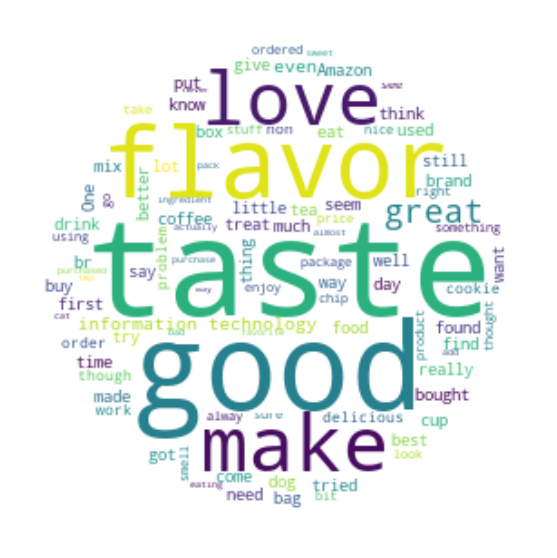

In [ ]:
word_plot(t_final_tokenized)

> stemming



```
I want to try two different stemmer
Lancaster should be more "aggressive" than Porter
```



In [ ]:
from nltk.stem import PorterStemmer

porter_stemmer = PorterStemmer()
t_final_tokenized_PS = t_final_tokenized.apply(lambda x: [porter_stemmer.stem(item) for item in x])
c2 = get_counter(t_final_tokenized_PS)
c2.most_common(20)

[('like', 21375),
 ('tast', 20473),
 ('flavor', 14920),
 ('good', 14256),
 ('coffe', 13614),
 ('tri', 12451),
 ('love', 11922),
 ('would', 10863),
 ('get', 10465),
 ('great', 10247),
 ('food', 9273),
 ('dog', 9265),
 ('make', 9259),
 ('tea', 8465),
 ('buy', 8082),
 ('time', 7366),
 ('realli', 7356),
 ('eat', 7045),
 ('much', 6920),
 ('order', 6736)]

> visualized the word in wordcloud

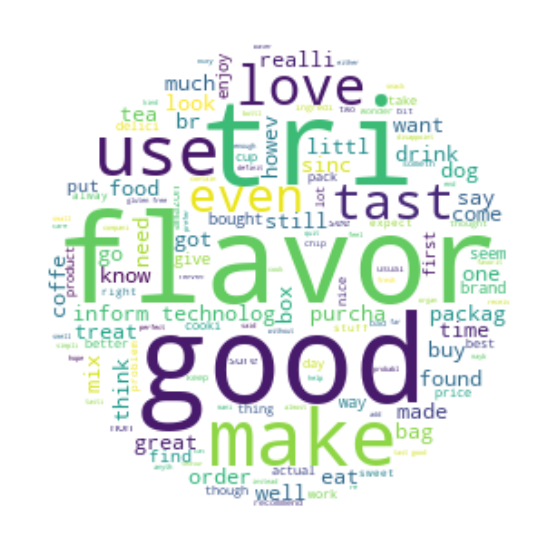

In [ ]:
word_plot(t_final_tokenized_PS)

#Supervised approach 




In [ ]:
def plot_pca(value,target):
  pca = PCA(n_components=2)
  projected = pca.fit_transform(value)
  print("bag of word dimension:",value.shape)
  print("PCA dimension:",projected.shape)

  plt.scatter(projected[:, 0], projected[:, 1],
              c=target, edgecolor='none', alpha=0.5,
              cmap=plt.cm.get_cmap('YlGnBu', 3))    

  plt.xlabel('component 1')
  plt.ylabel('component 2')
  plt.colorbar();

In [ ]:
count_vect = CountVectorizer(stop_words=None, lowercase=True, max_features=5000)
bow = count_vect.fit_transform(t_final_tokenized_PS.apply(lambda x: " ".join(x)))
print(bow.shape)
#print(bow.toarray())


(42739, 5000)


bag of word dimension: (42739, 5000)
PCA dimension: (42739, 2)


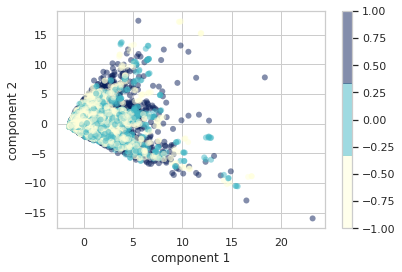

In [ ]:
# whole dataset
plot_pca(bow.toarray(), df.category_score)

In [ ]:
# df.category_score come label e non score per avere 3 possibili risultati (neg, neu, pos)
# se si vuole l'effettivo score usare df.score

X_train, X_test, Y_train, Y_test  = train_test_split(bow.toarray(), df.category_score, train_size=0.70, random_state=1234)


bag of word dimension: (12822, 5000)
PCA dimension: (12822, 2)


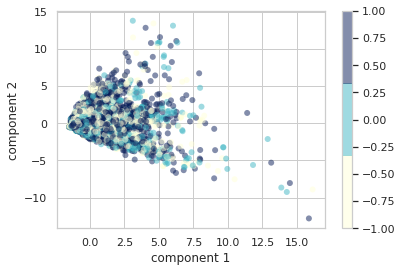

In [ ]:
# X_test
plot_pca(X_test, Y_test)

<h3>Logic Regression Model</h3>

In [ ]:
def plot_result(Y, y_pred):
  print("accuracy: {}".format(accuracy_score(Y, y_pred)))
  precision, recall, f_score, support = precision_recall_fscore_support(Y, y_pred, average = "weighted")
  print("precision: {}".format(precision))
  print("recall: {}".format(recall))
  print("f-score: {}".format(f_score), end="\n\n")

  confusion = pd.crosstab(Y, y_pred)                             
  #print(confusion)

  sns.heatmap(confusion, annot=True, fmt="d", cmap="YlGnBu", linewidths=.5)
  plt.title("Confusion matrix")
  plt.xlabel("prediction")
  plt.ylabel("Categoria score")

accuracy: 0.805490563094681
precision: 0.8131336828961908
recall: 0.805490563094681
f-score: 0.8083454412787797



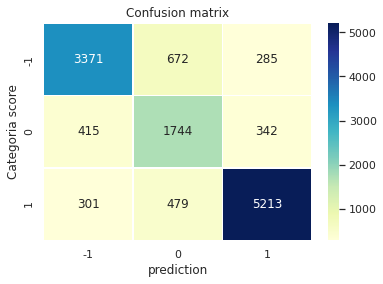

In [ ]:
log_model = LogisticRegression(C=0.5, max_iter = 200, class_weight='balanced')
log_model = log_model.fit(X=X_train, y=Y_train)  # fit(X_train, Y_train)

y_pred = log_model.predict(X_test)
plot_result(Y_test, y_pred)

In [ ]:

scoring = ['accuracy','f1_weighted','precision_weighted', 'recall_weighted']
log_model1 = LogisticRegression(C=0.5, max_iter = 200, class_weight='balanced')
scores = cross_validate(log_model1, X_train, Y_train, scoring=scoring, cv=10, verbose=1 ,return_train_score=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 28.6min finished


In [ ]:
print(sorted(scores.keys()))
print("acc: ",scores['test_accuracy'])
print("prec: ",scores['test_precision_weighted'])
print("recall: ",scores['test_recall_weighted'])
print("f1: ",scores['test_f1_weighted'])

['fit_time', 'score_time', 'test_accuracy', 'test_f1_weighted', 'test_precision_weighted', 'test_recall_weighted']
acc:  [0.79411765 0.80614973 0.79612299 0.79177807 0.80681818 0.78141711
 0.79512032 0.81678368 0.81578068 0.8004012 ]
prec:  [0.8076186  0.81230825 0.80613296 0.80115029 0.81271357 0.79275375
 0.80494525 0.82616713 0.8230279  0.80922836]
recall:  [0.79411765 0.80614973 0.79612299 0.79177807 0.80681818 0.78141711
 0.79512032 0.81678368 0.81578068 0.8004012 ]
f1:  [0.79911545 0.80868029 0.80005467 0.79555496 0.80930618 0.78549391
 0.79898693 0.82032974 0.81846745 0.80381232]


bag of word dimension: (12822, 5000)
PCA dimension: (12822, 2)


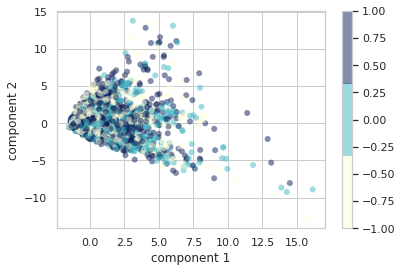

In [ ]:
plot_pca(X_test, y_pred)  # predette

<h2>random forest </h2>

accuracy: 0.8792700046794572
precision: 0.8857449618980247
recall: 0.8792700046794572
f-score: 0.874007986152466



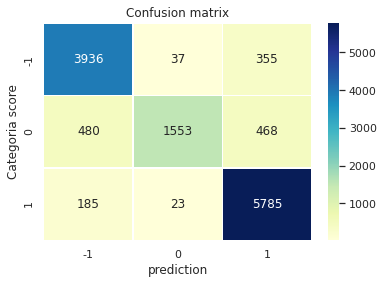

In [ ]:
rfc = RandomForestClassifier(n_estimators= 300, class_weight='balanced')
rfc.fit(X=X_train, y=Y_train)  # fit(X_train, Y_train)

y_pred_rf = rfc.predict(X_test)
plot_result(Y_test, y_pred_rf)

bag of word dimension: (12822, 5000)
PCA dimension: (12822, 2)


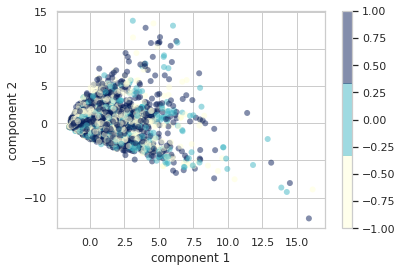

In [ ]:
plot_pca(X_test,y_pred_rf)

In [ ]:
rfc1 = RandomForestClassifier(n_estimators= 300, class_weight='balanced')
scoresrf = cross_validate(rfc1, X_train, Y_train, scoring=scoring, cv=10, verbose=1, return_train_score=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 31.7min finished


In [ ]:
print(sorted(scoresrf.keys()))
print("acc: ",scoresrf['test_accuracy'])
print("prec: ",scoresrf['test_precision_weighted'])
print("recall: ",scoresrf['test_recall_weighted'])
print("f1: ",scoresrf['test_f1_weighted'])

['fit_time', 'score_time', 'test_accuracy', 'test_f1_weighted', 'test_precision_weighted', 'test_recall_weighted']
acc:  [0.86931818 0.8776738  0.87165775 0.87165775 0.8709893  0.86263369
 0.87967914 0.8739552  0.88164493 0.87596122]
prec:  [0.87704434 0.88617984 0.87897724 0.8775538  0.87758787 0.86941772
 0.88530535 0.88156167 0.88867253 0.88082354]
recall:  [0.86931818 0.8776738  0.87165775 0.87165775 0.8709893  0.86263369
 0.87967914 0.8739552  0.88164493 0.87596122]
f1:  [0.86176904 0.87112332 0.86525191 0.86447015 0.86374153 0.85496438
 0.87434221 0.8672271  0.87477432 0.87100868]


In [ ]:
print(scores['test_accuracy'])

[0.79411765 0.80614973 0.79612299 0.79177807 0.80681818 0.78141711
 0.79512032 0.81678368 0.81578068 0.8004012 ]


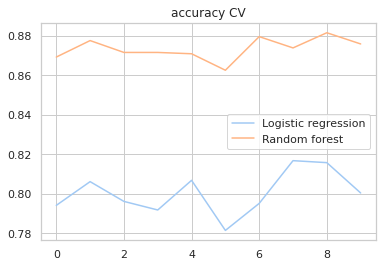

In [ ]:
plt.title("accuracy CV")
plt.plot(scores['test_accuracy'])
plt.plot(scoresrf['test_accuracy'])
plt.legend(['Logistic regression','Random forest'],loc="best")

# Unsupervised

> K-means

In [ ]:
def trasform_label(x):
  if x == 0:
    return -1
  if x == 1:
    return 0
  if x == 2:
    return 1

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(X_train)
y_pred_k = kmeans.predict(X_test)

for i in range(len(y_pred_k)):
  y_pred_k[i] = trasform_label(y_pred_k[i])


y_pred_k

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

accuracy: 0.4448603961940415
precision: 0.39110703465884294
recall: 0.4448603961940415
f-score: 0.37395536995929163



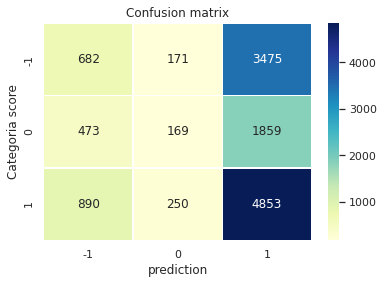

In [ ]:
plot_result(Y_test, y_pred_k)

bag of word dimension: (12822, 5000)
PCA dimension: (12822, 2)


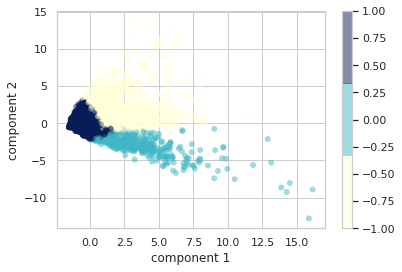

In [ ]:
plot_pca(X_test,y_pred_k)

In [ ]:
del X_test
del Y_test
del X_train
del Y_train
del kmeans
del rfc
del log_model

#word2vec-google-news-300

In [ ]:
def simple_preproc(text):
  """
  see: https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string
  """
  return text.translate(str.maketrans('', '', string.punctuation))

In [ ]:
def naive_sentence_embedding(text, embedding, mean_embedding):
  """
  Embeds a sentence by making the average of the word embedding in the sentence
  There are several ways to make this better and smarter.
  Google "sentence embeddings"

  if a word is missing from the vocabulary we add this generic mean vecor 
  of the entire space
  """
  text = simple_preproc(text.lower())
  collect = []
  for a in text.split():
    if a in embedding.vocab:
      collect.append(embedding[a])
    else:
      collect.append(mean_embedding)

  return np.mean(collect, axis=0)

In [ ]:
model = api.load("word2vec-google-news-300")
mean_vector = np.mean(model[model.vocab], axis=0) 

[=================================================-] 98.9% 1645.2/1662.8MB downloaded


#### plot embedding

In [ ]:
def quick_plot(words, embedding):
  
  X = embedding[words]
  pca = PCA(n_components=2)
  
  two_d_emb = pca.fit_transform(X)

  plt.scatter(two_d_emb[:, 0], two_d_emb[:, 1])

  for index, word in enumerate(words):
    # annotate
    plt.annotate(word, xy=(two_d_emb[index, 0], two_d_emb[index, 1]))

  plt.xlabel('Component 1')
  plt.ylabel('Component 2')
  plt.show()

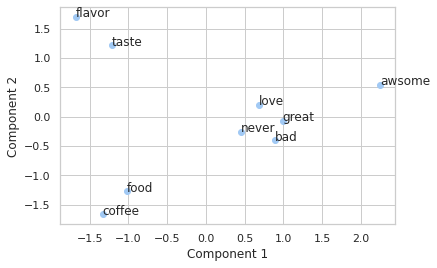

In [ ]:
quick_plot(["great","love","food","never","bad","awsome", "coffee","flavor", "taste"], model)

### train & predict

In [ ]:
def embedding_pred(model, mean_vector, testo, label):

  train_X = np.array([naive_sentence_embedding(tt, model, mean_vector) for tt in testo])

  X_train, X_test, y_train, y_test = train_test_split(train_X, label, train_size=0.80, random_state=42, shuffle=True)

  model_kn = KNeighborsClassifier(n_neighbors=3)
  #model_kn = RandomForestClassifier(n_estimators= 300, class_weight='balanced')
  #model_kn = LogisticRegression()
  model_kn.fit(X_train, y_train)
  y_pred = model_kn.predict(X_test)

  confusion = pd.crosstab(y_test, y_pred)                              

  sns.heatmap(confusion, annot=True, fmt="d", cmap="YlGnBu", linewidths=.5)
  plt.title('Confusion matrix')
  plt.ylabel("Categoria score")
  plt.xlabel("Prediction")

  print("accuracy: {}".format(accuracy_score(y_pred, y_test)))
  precision, recall, f_score, support = precision_recall_fscore_support(y_test, y_pred, average = "weighted")
  print("precision: {}".format(precision))
  print("recall: {}".format(recall))
  print("f-score: {}".format(f_score), end="\n\n")

  #plot_pca(X_test,y_pred)

  return model_kn

In [ ]:
def preprocess_wordembedd(text):
    tokens = nltk.word_tokenize(text)
    # rimuovi stop word
    # rimuovi punteggiatura
    tokens = [item for item in tokens if item not in stop]
    tokens = [item for item in tokens if item not in punctuation]
    tokens = [porter_stemmer.stem(item) for item in tokens]
    tokens = " ".join(tokens)
    return tokens

In [ ]:
testo = df['text']
label = df['category_score']
lista = []
lista = testo.apply(lambda x: preprocess_wordembedd(x))
#print(testo)
#print()
#print(lista)

> ho provato sia con il testo sia con il testo processato e ottengo performance migliori del 0.5% con il testo non processato

accuracy: 0.7930510060832944
precision: 0.8024090957276027
recall: 0.7930510060832944
f-score: 0.7942694530824276



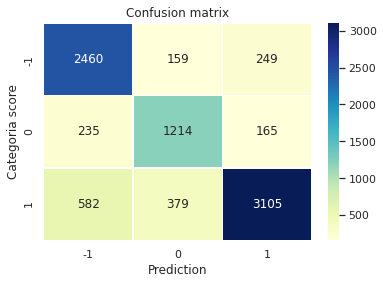

In [ ]:
model1 = embedding_pred(model, mean_vector, testo, label)

accuracy: 0.6692793635938231
precision: 0.6571634126527547
recall: 0.6692793635938231
f-score: 0.6532549634997399



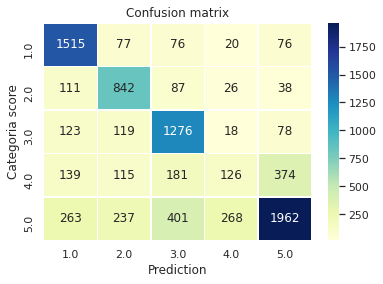

In [ ]:
label = df['score']
model2 = embedding_pred(model, mean_vector, testo, label)

Sanity check !!

Sono esempi di recensioni che ho preso da amazon

In [ ]:
# aveva come score 5
example = "Great price on these solid little blue tooth earbuds. Use them on my commute and day to day listening. the battery life is good and between non use when I put them back in their case the battery has not run out yet."
embedding_example = naive_sentence_embedding(preprocess_wordembedd(example), model, mean_vector)

print("Secondo il model1 la recensione è nella categoria: {}".format(model1.predict(np.array([embedding_example]))))
print("Secondo il model2 la recensione ha score: {}".format(model2.predict(np.array([embedding_example]))))

Secondo il model1 la recensione è nella categoria: [1]
Secondo il model2 la recensione ha score: [5.]


In [ ]:
# aveva come score 3 task più difficile
example = " Like that its compact and comes with adapter to play 45's. Red and white rca outputs in back. I'll plug into a mixer then the skies the limit once I get the replacement. Plugged a bluetooth transmitter into headphone jack then paired with Amazon Echo. Be sure to play last song till the end on all size records as 'auto off' feature can be defective as shown in video. Built in Bluetooth is a receiver not a transmitter and worked perfectly. Built in speakers worked perfectly. ALL manufacturers sometimes produce lemons. I will lower rating if replacement is also defective."
embedding_example = naive_sentence_embedding(preprocess_wordembedd(example), model, mean_vector)

print("Secondo il model1 la recensione è nella categoria: {}".format(model1.predict(np.array([embedding_example]))))
print("Secondo il model2 la recensione ha score: {}".format(model2.predict(np.array([embedding_example]))))

Secondo il model1 la recensione è nella categoria: [1]
Secondo il model2 la recensione ha score: [2.]
